# **Project 1 - Team 3 - Essmer Sanchez**

## **Top 3 Best Problems**

**Q1**  
**Proposition:** Summarize the total sales and the number of orders per salesperson for --each territory in 2014, identifying top territories based on total sales. (complex)

- **Tables Used:** A Join between Sales.SalesPerson (SP), Sales.SalesOrderHeader (SOH)
- **SQL Functions:** SUM() for TotalSales, COUNT() for OrderCount, YEAR() to compare to 2014.
- **Aggregation:** Group by SP.BusinessEntitiyID, SP.TerritoryID.
- **CTE Usage** Created SalesSummary, TopTerritories.
- **Set Operators** UNION ALL
- **Output** Display BusinessEntityID, TerritoryID, TotalSales, OrderCount

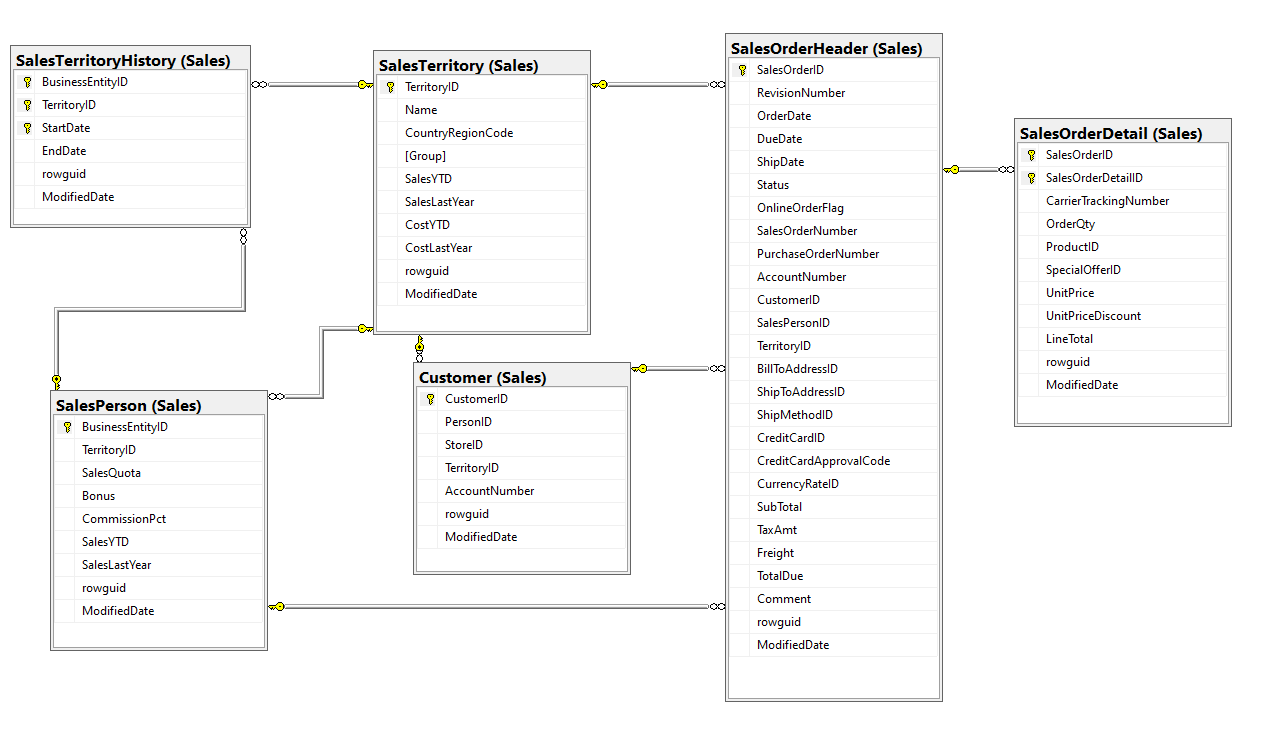

In [ ]:

USE AdventureWorks2017;

WITH SalesSummary AS (
	SELECT SP.BusinessEntityID, SP.TerritoryID,
		SUM(SOH.SubTotal) AS TotalSales,
		COUNT(SOH.SalesOrderID) AS OrderCount
	FROM Sales.SalesPerson AS SP
		JOIN Sales.SalesOrderHeader AS SOH
			ON SP.BusinessEntityID = SOH.SalesPersonID
	WHERE YEAR(SOH.OrderDate) = 2014
	GROUP BY SP.BusinessEntityID, SP.TerritoryID
),
TopTerritories AS (
	SELECT TOP 3 TerritoryID
	FROM SalesSummary
	GROUP BY TerritoryID
	ORDER BY SUM(TotalSales) DESC
)
SELECT SP.BusinessEntityID, SP.TerritoryID, SS.TotalSales, SS.OrderCount
FROM SalesSummary AS SS
	JOIN Sales.SalesPerson AS SP
		ON SS.BusinessEntityID = SP.BusinessEntityID
WHERE SP.TerritoryID IN (SELECT TerritoryID
						 FROM TopTerritories)
UNION ALL

SELECT SP.BusinessEntityID, SP.TerritoryID, SS.TotalSales, SS.OrderCount
FROM SalesSummary SS
	JOIN Sales.SalesPerson AS SP
		ON SS.BusinessEntityID = SP.BusinessEntityID
WHERE SP.TerritoryID NOT IN (SELECT TerritoryID
							 FROM TopTerritories)
ORDER BY SP.TerritoryID, TotalSales DESC;



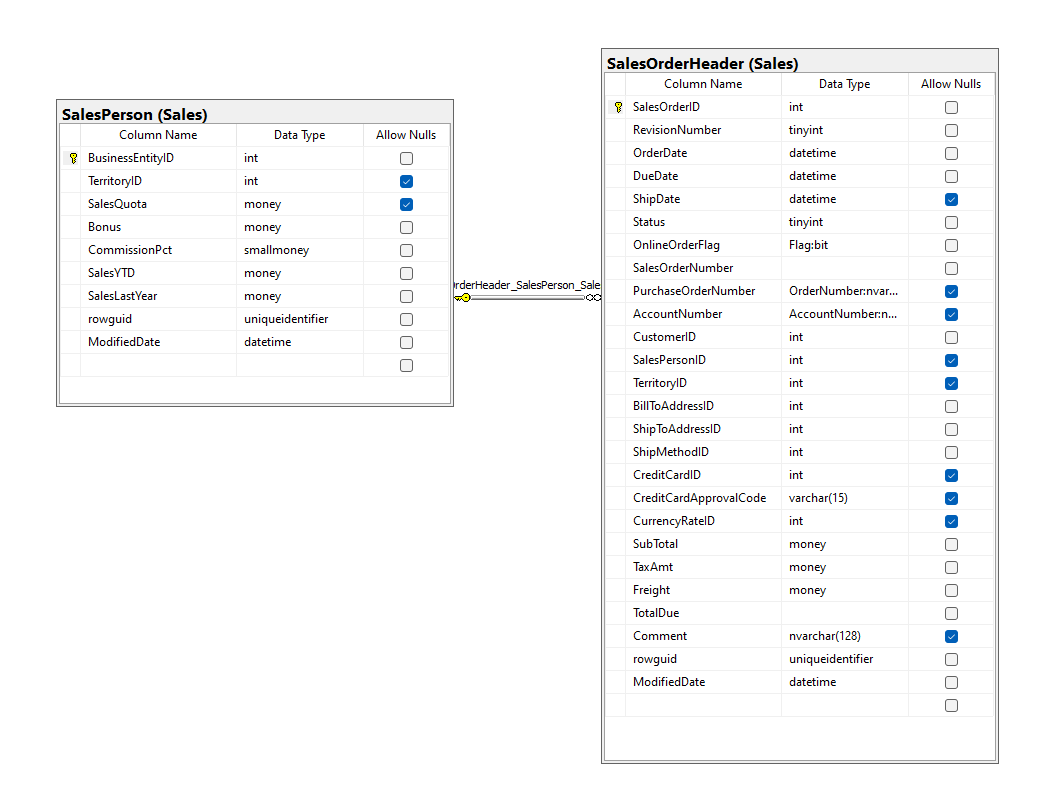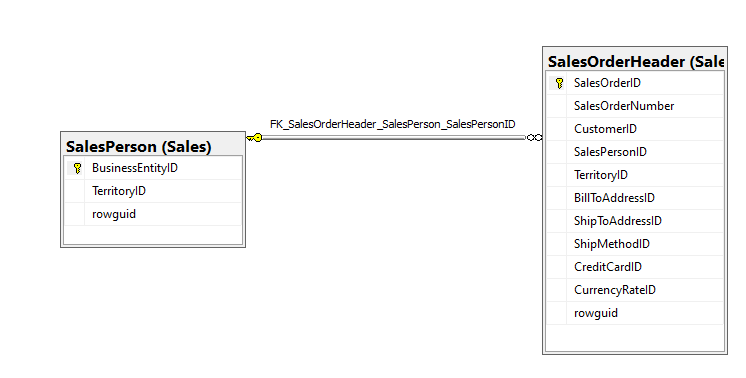

In [ ]:
USE AdventureWorks2017;
GO

;WITH SalesSummary AS (
    SELECT SP.BusinessEntityID, SP.TerritoryID,
        SUM(SOH.SubTotal) AS TotalSales,
        COUNT(SOH.SalesOrderID) AS OrderCount
    FROM Sales.SalesPerson AS SP
    JOIN Sales.SalesOrderHeader AS SOH ON SP.BusinessEntityID = SOH.SalesPersonID
    WHERE YEAR(SOH.OrderDate) = 2014
    GROUP BY SP.BusinessEntityID, SP.TerritoryID
),
TopTerritories AS (
    SELECT TOP 3 TerritoryID
    FROM SalesSummary
    GROUP BY TerritoryID
    ORDER BY SUM(TotalSales) DESC
)
SELECT SP.BusinessEntityID, SP.TerritoryID, SS.TotalSales, SS.OrderCount
FROM SalesSummary AS SS
JOIN Sales.SalesPerson AS SP ON SS.BusinessEntityID = SP.BusinessEntityID
WHERE SP.TerritoryID IN (SELECT TerritoryID FROM TopTerritories)
UNION ALL
SELECT SP.BusinessEntityID, SP.TerritoryID, SS.TotalSales, SS.OrderCount
FROM SalesSummary AS SS
JOIN Sales.SalesPerson AS SP ON SS.BusinessEntityID = SP.BusinessEntityID
WHERE SP.TerritoryID NOT IN (SELECT TerritoryID FROM TopTerritories)
ORDER BY SP.TerritoryID, TotalSales DESC
FOR JSON AUTO;

**Q2**  
**Proposition:** Determine the annual growth rate of sales per product category from 2013 to 2014. (complex)

*   **Tables Used:** Join of Sales.SalesOrderDetail, Sales.SalesOrderHeader, Production.Product, and between CTE's SalesData and YearlyComparison.
*   **Custom Scalar Function** FUNCTION dbo.CalculateGrowthRate
*   **SQL Functions:** DECIMAL(), SUM(), YEAR().
*   **Aggregation:** Join ON and GROUP BY usage in CTE's. Final presentation GROUP BY YearlyComparison growth rate. 
*   **CTE Usage** Created SalesSummary, TopTerritories.
*   **Output** Display CatergoryName, YC.Sales2013, YC.Sales2014, YC.GrowthRate

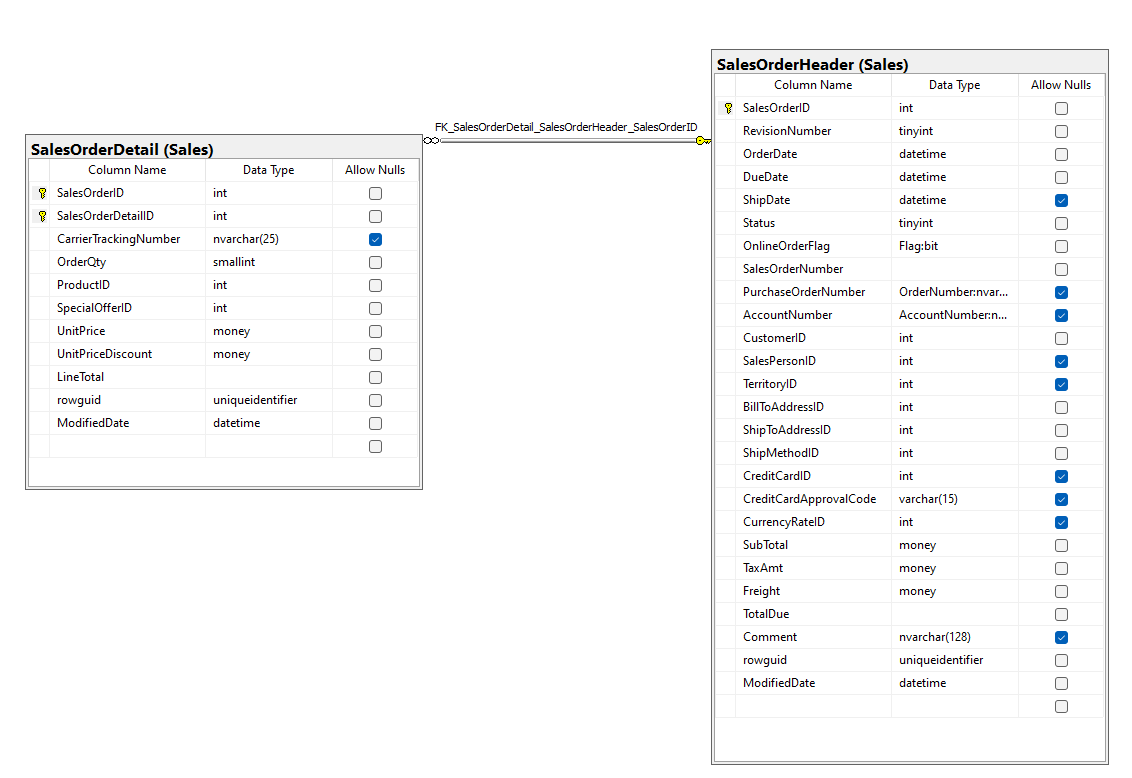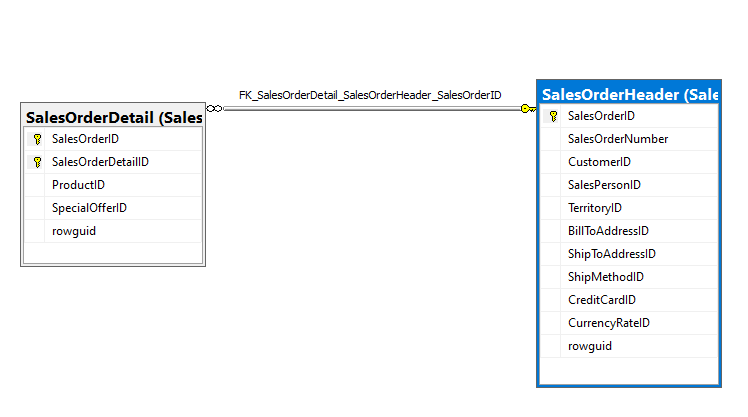

In [ ]:
USE AdventureWorks2017;
GO

CREATE OR ALTER FUNCTION dbo.CalculateGrowthRate (
	@PreviousPeriodTotal DECIMAL(10,2),
	@CurrentPeriodTotal DECIMAL(10,2)
)
RETURNS DECIMAL (6,2)
AS
BEGIN
	RETURN CASE
				WHEN @PreviousPeriodTotal = 0 THEN NULL
				ELSE (@CurrentPeriodTotal - @PreviousPeriodTotal) / @PreviousPeriodTotal
			END;
END;
GO
WITH SalesData AS (
	SELECT P.ProductSubcategoryID, YEAR(SOH.OrderDate) AS OrderYear,
		SUM(SOD.LineTotal) AS TotalSales
	FROM Sales.SalesOrderDetail AS SOD
		JOIN Sales.SalesOrderHeader AS SOH
			ON SOD.SalesOrderDetailID = SOH.SalesOrderID
		JOIN Production.Product AS P
			ON SOD.ProductID = P.ProductID
	WHERE YEAR(SOH.OrderDate) IN (2013, 2014)
	GROUP BY P.ProductSubcategoryID, YEAR(SOH.OrderDate)
),
YearlyComparison AS (
	SELECT SD2013.ProductSubcategoryID, SD2013.TotalSales AS Sales2013,
		SD2014.TotalSales AS Sales2014,
		dbo.CalculateGrowthRate(SD2013.TotalSales, SD2014.TotalSales) AS GrowthRate
	FROM SalesData AS SD2013
		JOIN SalesData AS SD2014
			ON SD2013.ProductSubcategoryID = SD2014.ProductSubcategoryID
		WHERE SD2013.OrderYear = 2013 and SD2014.OrderYear = 2014
)
SELECT PC.Name AS CatergoryName, YC.Sales2013, YC.Sales2014, YC.GrowthRate
FROM YearlyComparison YC
	JOIN Production.ProductCategory AS PC
		ON YC.ProductSubcategoryID = PC.ProductCategoryID
ORDER BY YC.GrowthRate DESC;

In [ ]:
USE AdventureWorks2017;

;WITH SalesData AS (
    SELECT P.ProductSubcategoryID, YEAR(SOH.OrderDate) AS OrderYear,
        SUM(SOD.LineTotal) AS TotalSales
    FROM Sales.SalesOrderDetail AS SOD
    JOIN Sales.SalesOrderHeader AS SOH ON SOD.SalesOrderDetailID = SOH.SalesOrderID
    JOIN Production.Product AS P ON SOD.ProductID = P.ProductID
    WHERE YEAR(SOH.OrderDate) IN (2013, 2014)
    GROUP BY P.ProductSubcategoryID, YEAR(SOH.OrderDate)
),
YearlyComparison AS (
    SELECT SD2013.ProductSubcategoryID, SD2013.TotalSales AS Sales2013,
        SD2014.TotalSales AS Sales2014,
        dbo.CalculateGrowthRate(SD2013.TotalSales, SD2014.TotalSales) AS GrowthRate
    FROM SalesData AS SD2013
    JOIN SalesData AS SD2014 ON SD2013.ProductSubcategoryID = SD2014.ProductSubcategoryID
    WHERE SD2013.OrderYear = 2013 AND SD2014.OrderYear = 2014
)
SELECT PC.Name AS CategoryName, YC.Sales2013, YC.Sales2014, YC.GrowthRate
FROM YearlyComparison YC
JOIN Production.ProductCategory AS PC ON YC.ProductSubcategoryID = PC.ProductCategoryID
ORDER BY YC.GrowthRate DESC
FOR JSON PATH;

**Q3**  
**Proposition:** Create a view that creates a group of sales by customer and year summarized by total sales amount. Find the maximum sales year for each customer and count the number of orders per customer. (complex)

*   **Tables Used:** Joined tables are dbo.FactInternetSales, dbo.DimDate, View Table CustomerYearlySales. 
*   **Table View** CustomerYearlySales
*   **SQL Functions:** YEAR(), SUM(), MAX(), COUNT().
*   **Aggregation:** GROUP BY used in Views, final display ORDER BY view table TotalSalesAmount.
*   **Output** Top 20 CustomerKey, First Name, Last Name, Sales Year.

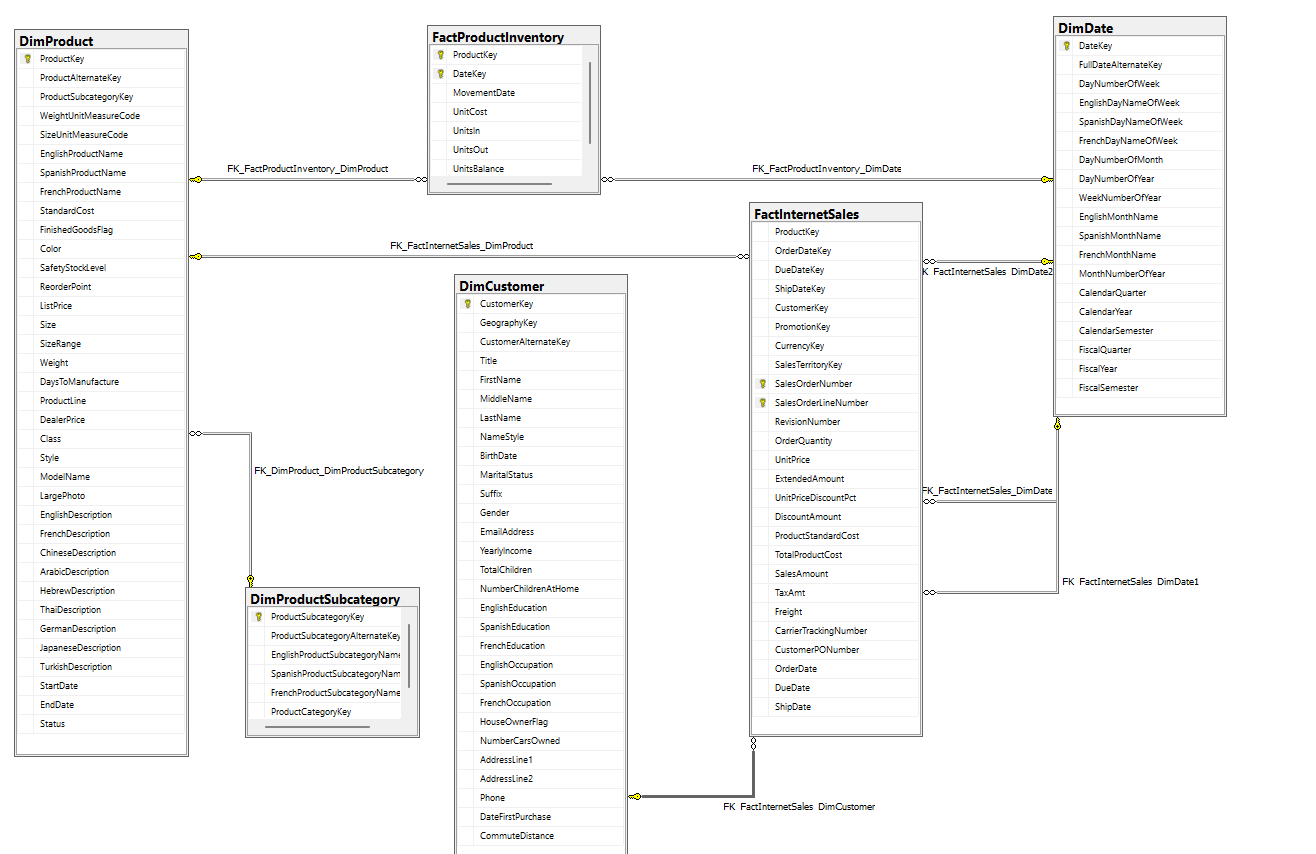

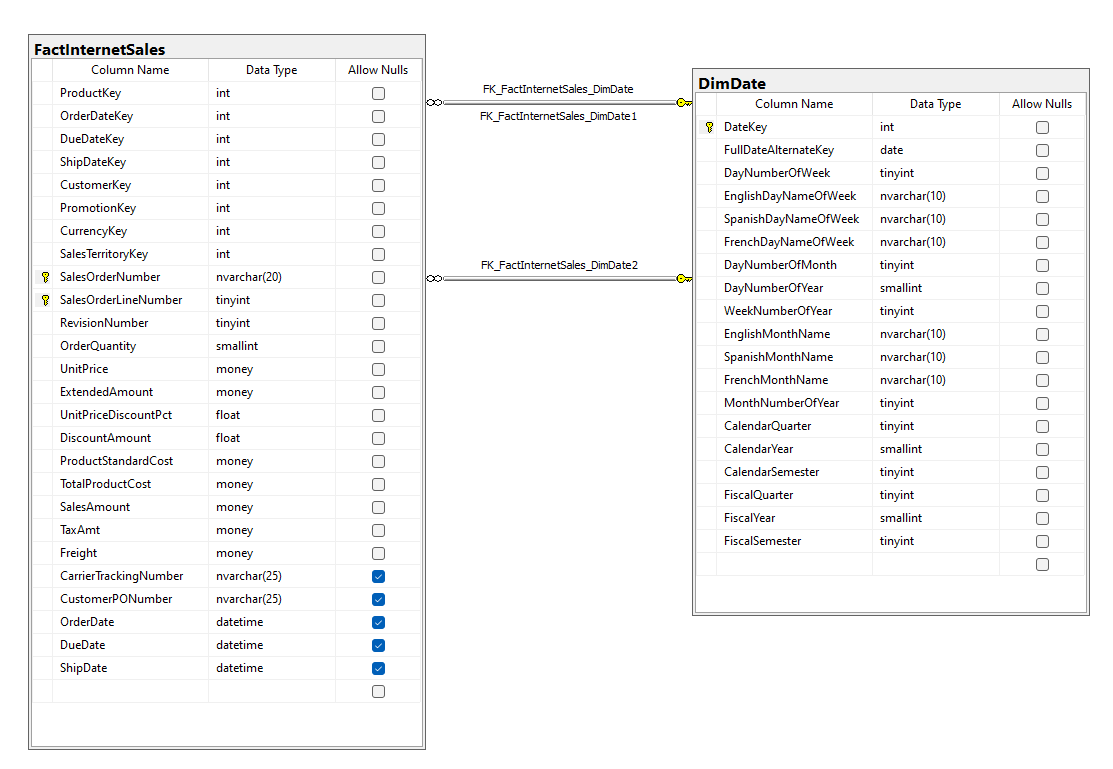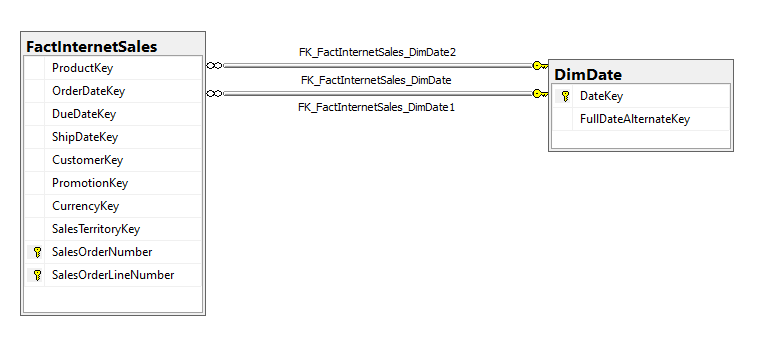

In [ ]:

USE AdventureWorksDW2017;
GO

CREATE OR ALTER VIEW CustomerYearlySales AS
SELECT FIS.CustomerKey, YEAR(D.FullDateAlternateKey) AS SalesYear,
       SUM(FIS.SalesAmount) AS TotalSalesAmount
FROM dbo.FactInternetSales AS FIS
JOIN dbo.DimDate AS D ON FIS.OrderDateKey = D.DateKey 
GROUP BY FIS.CustomerKey, YEAR(D.FullDateAlternateKey);
GO

SELECT TOP 20 DC.CustomerKey, DC.FirstName, DC.LastName, CYS.SalesYear,
       CYS.TotalSalesAmount, 
       (SELECT MAX(SalesYear)
        FROM CustomerYearlySales
        WHERE CustomerKey = DC.CustomerKey) AS MaxSalesYear,
       (SELECT COUNT(*)
        FROM dbo.FactInternetSales AS FIS
        JOIN dbo.DimDate AS DD ON FIS.OrderDateKey = DD.DateKey
        WHERE FIS.CustomerKey = DC.CustomerKey AND YEAR(DD.FullDateAlternateKey) = CYS.SalesYear) AS OrderCountInSalesYear
FROM dbo.DimCustomer AS DC
JOIN CustomerYearlySales CYS ON DC.CustomerKey = CYS.CustomerKey
WHERE CYS.SalesYear = (SELECT MAX(SalesYear)
                       FROM CustomerYearlySales
                       WHERE CustomerKey = DC.CustomerKey)
ORDER BY CYS.TotalSalesAmount DESC;

In [ ]:
USE AdventureWorksDW2017;


SELECT TOP 20 DC.CustomerKey, DC.FirstName, DC.LastName, CYS.SalesYear,
       CYS.TotalSalesAmount,
       (SELECT MAX(SalesYear)
        FROM CustomerYearlySales
        WHERE CustomerKey = DC.CustomerKey) AS MaxSalesYear,
       (SELECT COUNT(*)
        FROM dbo.FactInternetSales AS FIS
        JOIN dbo.DimDate AS DD ON FIS.OrderDateKey = DD.DateKey
        WHERE FIS.CustomerKey = DC.CustomerKey AND YEAR(DD.FullDateAlternateKey) = CYS.SalesYear) AS OrderCountInSalesYear
FROM dbo.DimCustomer AS DC
JOIN CustomerYearlySales CYS ON DC.CustomerKey = CYS.CustomerKey
WHERE CYS.SalesYear = (SELECT MAX(SalesYear)
                       FROM CustomerYearlySales
                       WHERE CustomerKey = DC.CustomerKey)
ORDER BY CYS.TotalSalesAmount DESC
FOR JSON PATH;

## **Top 3 Worst Problems**

**Q4**  
**Proposition:** Compare total sales amount and number of orders by city for two consecutive years, 2016 vs 2017.

*   **Tables Used:** Join on Fact.Sale, Dimension.Date.
*   **SQL Functions:** COUNT(), SUM().
*   **Aggregation:** GROUP BY in CTE, ORDER BY city and year based off CTE.
*   **CTE Usage** Created CitySales.
*   **Set Operators** UNION ALL
*   **Output** City, TotalSalesAmount, TotalOrders.  
This is a bad query since the table names were not correcly created, the use of brackets [] is needed to use the tables.

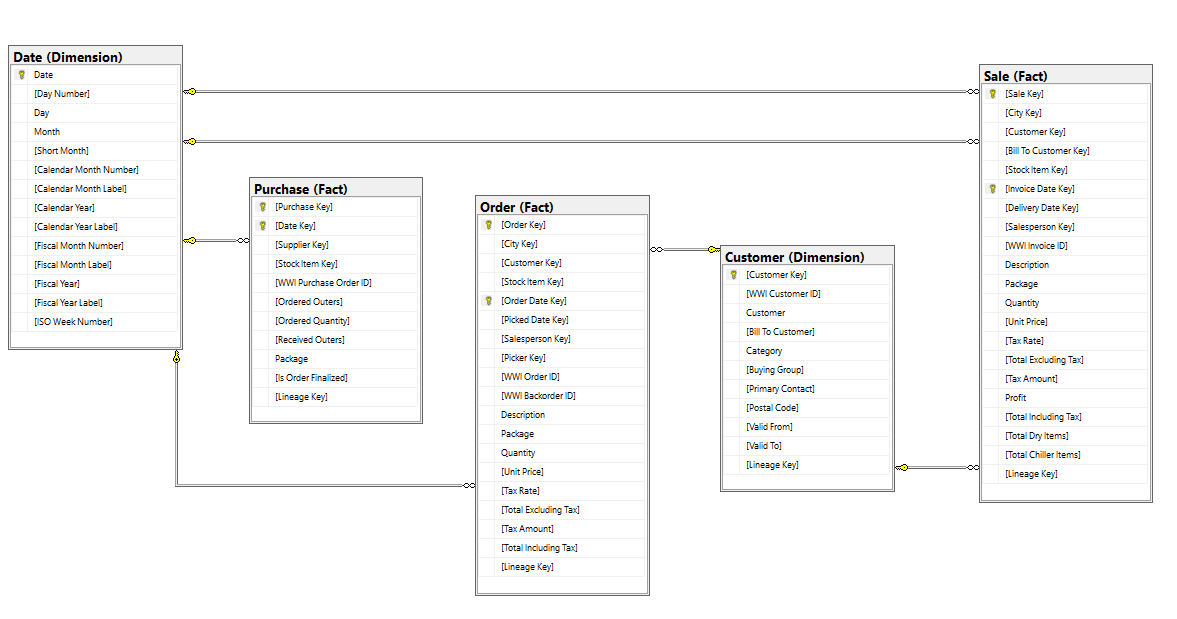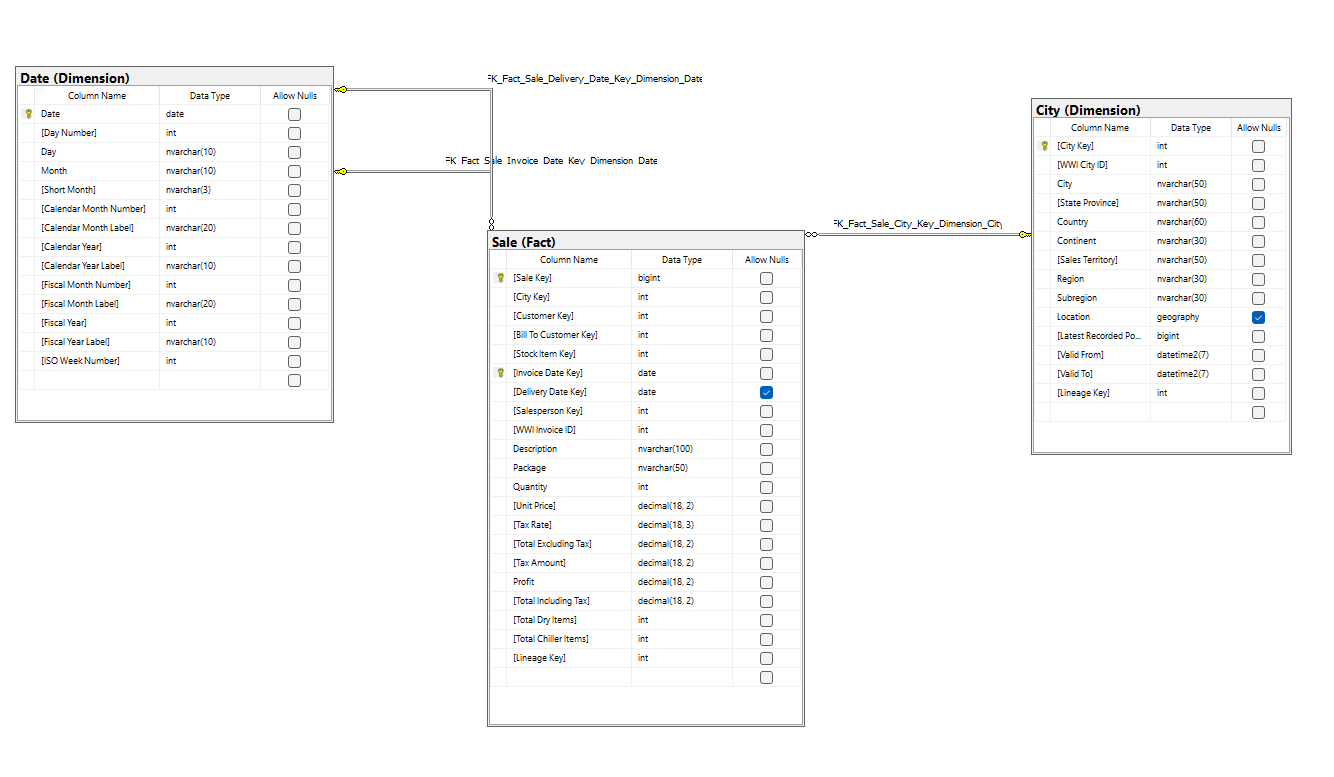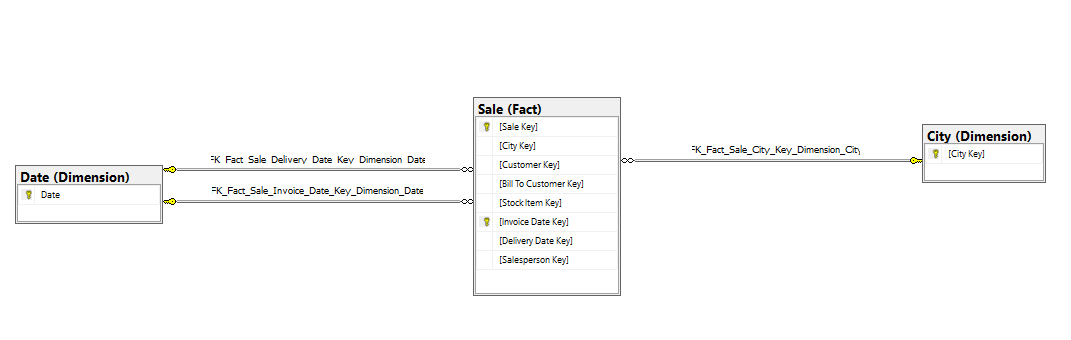

In [ ]:
USE WideWorldImportersDW;

WITH CitySales AS (
	SELECT DC.City, DD.[Calendar Year], SUM(FS.[Total Excluding Tax]) AS TotalSalesAmount,
	COUNT(FS.[Sale Key]) AS TotalOrders
	FROM Fact.Sale AS FS
		JOIN Dimension.Date AS DD
			ON FS.[Delivery Date Key] = DD.Date
		JOIN Dimension.City AS DC
			ON FS.[City Key] = DC.[City Key]
	WHERE DD.[Calendar Year] IN (2015,2016)
	GROUP BY DC.City, DD.[Calendar Year]
)
SELECT '2015' AS Year, City, TotalSalesAmount, TotalOrders
FROM CitySales
WHERE [Calendar Year] = 2015

UNION ALL

SELECT '2016' AS Year, City, TotalSalesAmount, TotalOrders
FROM CitySales
WHERE [Calendar Year] = 2016

ORDER BY City, Year;

In [ ]:
USE WideWorldImportersDW;

WITH CitySales AS (
    SELECT DC.City, DD.[Calendar Year], SUM(FS.[Total Excluding Tax]) AS TotalSalesAmount,
    COUNT(FS.[Sale Key]) AS TotalOrders
    FROM Fact.Sale AS FS
    JOIN Dimension.Date AS DD ON FS.[Delivery Date Key] = DD.Date
    JOIN Dimension.City AS DC ON FS.[City Key] = DC.[City Key]
    WHERE DD.[Calendar Year] IN (2015, 2016)
    GROUP BY DC.City, DD.[Calendar Year]
)
SELECT *
FROM (
    SELECT '2015' AS Year, City, TotalSalesAmount, TotalOrders
    FROM CitySales
    WHERE [Calendar Year] = 2015
    UNION ALL
    SELECT '2016' AS Year, City, TotalSalesAmount, TotalOrders
    FROM CitySales
    WHERE [Calendar Year] = 2016
) AS CombinedResults
ORDER BY City, Year
FOR JSON PATH;

**Q5**  
**Proposition:** Find the number of suppliers and custiomers in each city and rank these cities based on the total number of suppliers and customers combined.(complex)

- **Tables Used:** Join on Website.Customers and Website.Suppliers.
- **SQL Functions:** SUM(), RANK() OVER()
- **Aggregation:** GROUP BY in CTE, ORDER BY city and year based off CTE.
- **CTE Usage** Created CityTotal.
- **Set Operators** UNION ALL
- **Output** CityName, TotalCustomers, TotalSuppliers,CombinedCount, CityRank.This query is bad due to heavy redundancy in aggregation. It aggregates twice, first with UNION ALL then after the UNION. The final rank display is not properly shown.

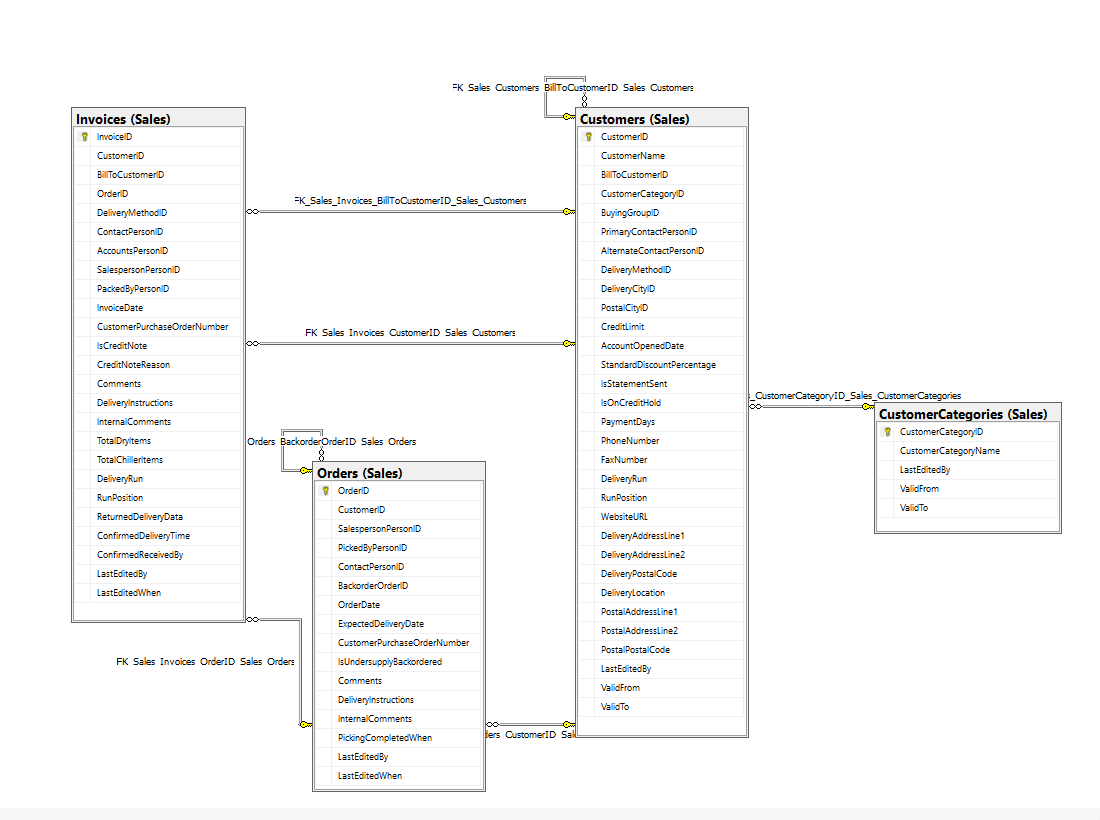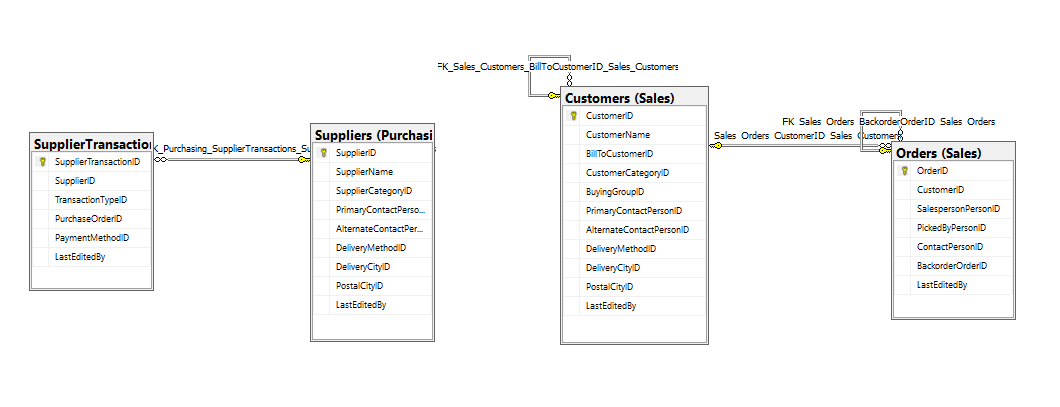

In [ ]:
USE WideWorldImporters;

WITH CityTotal AS (
	SELECT CityName, 'Customer' AS EntityType, COUNT(*) AS EntityCount
	FROM Website.Customers
	GROUP BY CityName

	UNION ALL

	SELECT CityName, 'Supplier' AS EntityType, COUNT(*) AS EntityCount
	FROM Website.Suppliers
	GROUP BY CityName
)
SELECT CityName, SUM(CASE
						WHEN EntityType = 'Customer' THEN EntityCount
						ELSE 0
						END) AS TotalCustomers,
				 SUM(CASE
						WHEN EntityType = 'Supplier' THEN EntityCount
						ELSE 0
						END) AS TotalSuppliers,
				 SUM(EntityCount) AS CombinedCount,
				 RANK() OVER (ORDER BY SUM(EntityCount) DESC) AS CityRank
FROM CityTotal
GROUP BY CityName
ORDER BY CombinedCount DESC;

In [ ]:
USE WideWorldImporters;

WITH CityTotal AS (
    SELECT CityName, 'Customer' AS EntityType, COUNT(*) AS EntityCount
    FROM Website.Customers
    GROUP BY CityName

    UNION ALL

    SELECT CityName, 'Supplier' AS EntityType, COUNT(*) AS EntityCount
    FROM Website.Suppliers
    GROUP BY CityName
)
SELECT CityName, 
       SUM(CASE WHEN EntityType = 'Customer' THEN EntityCount ELSE 0 END) AS TotalCustomers,
       SUM(CASE WHEN EntityType = 'Supplier' THEN EntityCount ELSE 0 END) AS TotalSuppliers,
       SUM(EntityCount) AS CombinedCount,
       RANK() OVER (ORDER BY SUM(EntityCount) DESC) AS CityRank
FROM CityTotal
GROUP BY CityName
ORDER BY CombinedCount DESC
FOR JSON PATH;

**Q6**
**Proposition:** Find all stock items, their group names, average purchase price
and the total amount of times each item has been ordered.

*   **Tables Used:** Join on Website.Customers and Website.Suppliers.
*   **SQL Functions:** SUM(), RANK() OVER()
*   **Aggregation:** GROUP BY in CTE, ORDER BY city and year based off CTE.
*   **CTE Usage** Created CityTotal.
*   **Set Operators** UNION ALL
*   **Output** CityName, TotalCustomers, TotalSuppliers,CombinedCount, CityRank.  
This query is bad due to heavy redundancy in aggregation. It aggregates twice, first with UNION ALL then after the UNION. The final rank display is not properly shown.

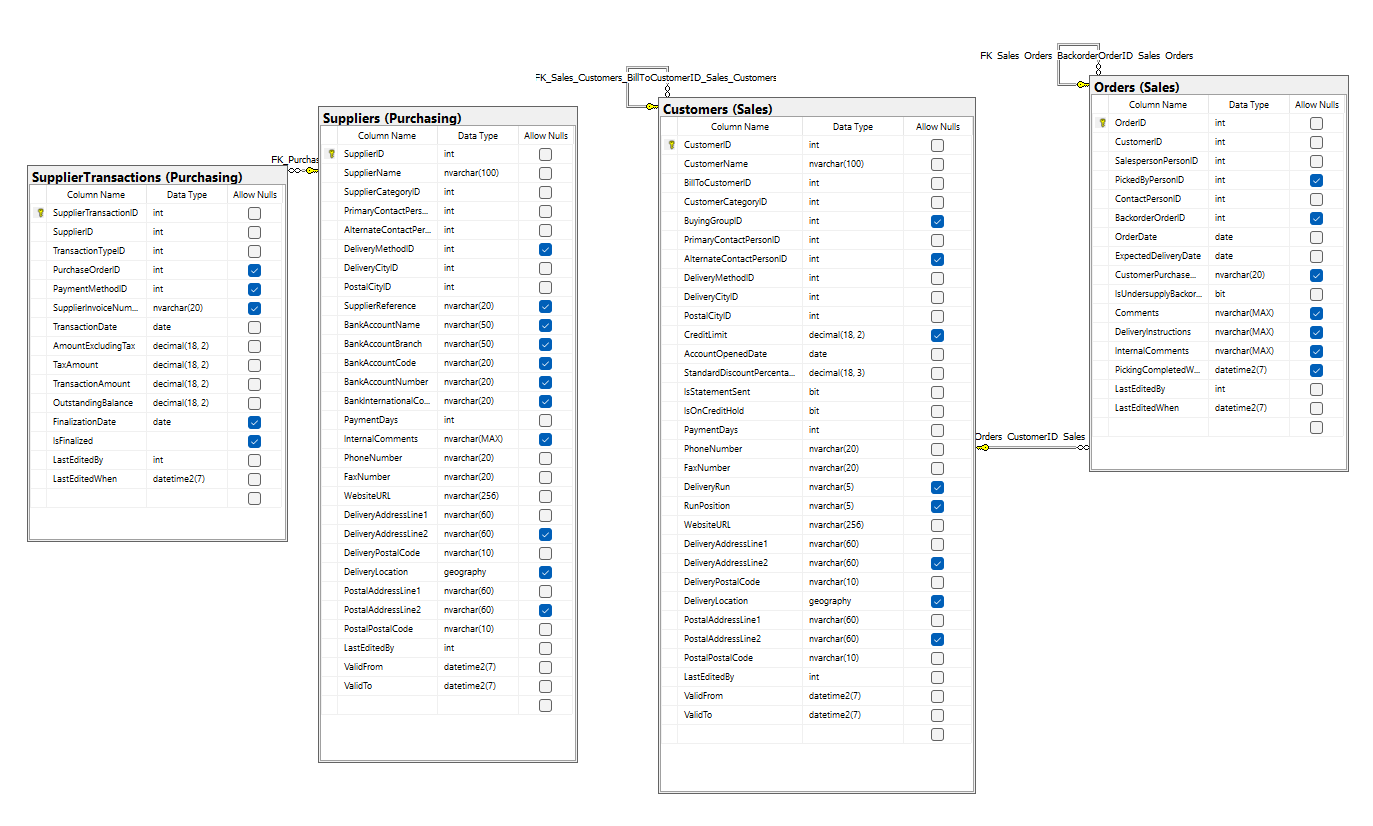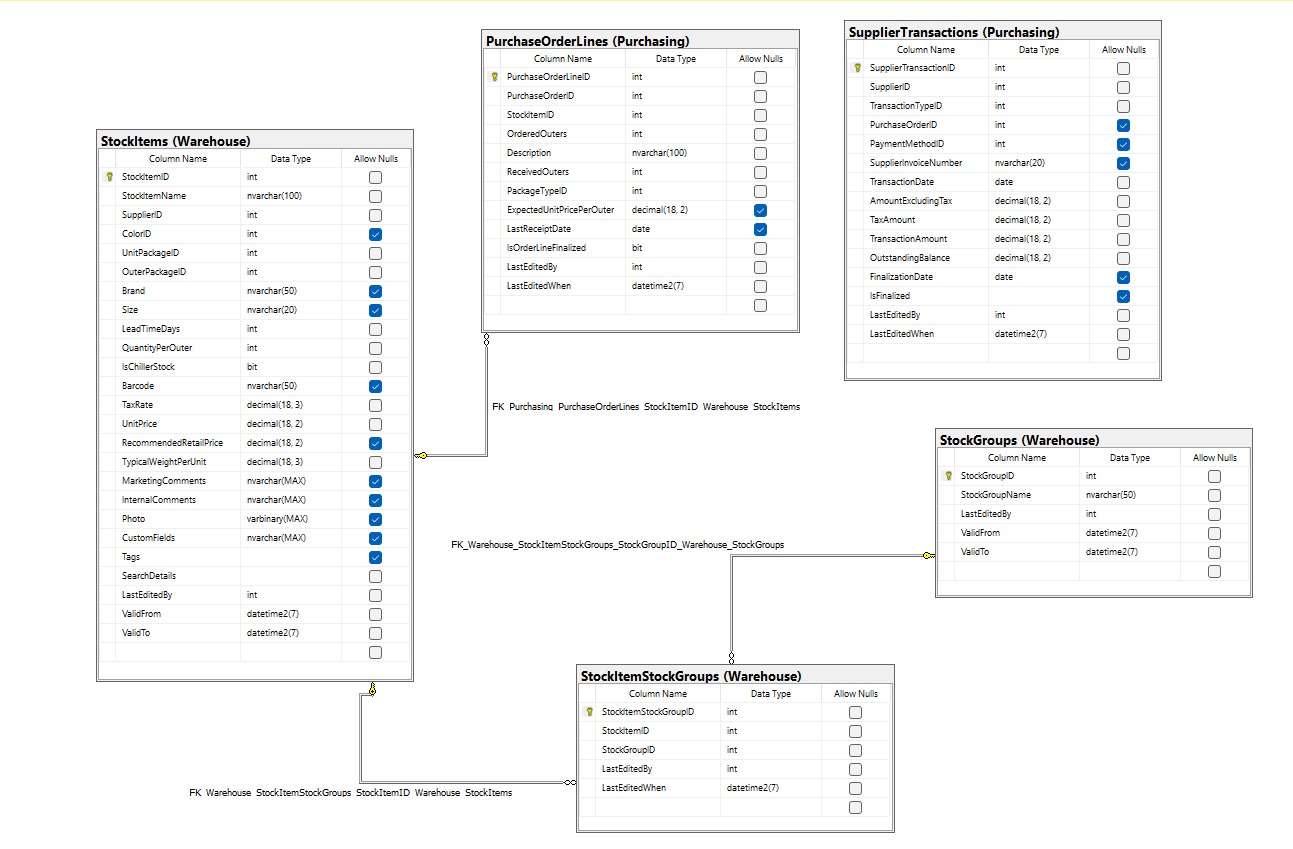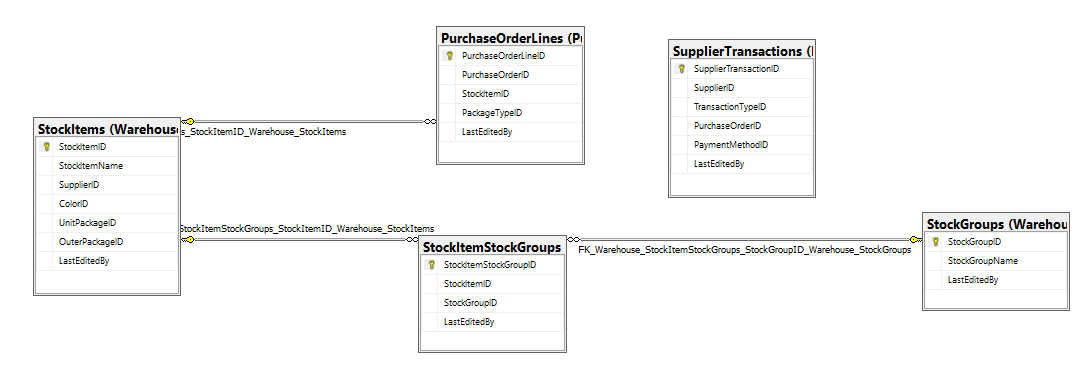

In [ ]:
USE WideWorldImporters;

SELECT SI.StockItemID, SI.StockItemName, SG.StockGroupName,
	(SELECT AVG(TransactionAmount)
	 FROM Purchasing.SupplierTransactions
	 WHERE SupplierID = SI.SupplierID) AS AvgPurchasePrice,
	 (SELECT COUNT(*)
	  FROM Purchasing.PurchaseOrderLines
	  WHERE StockItemID = SI.StockItemID) AS OrderCount
FROM Warehouse.StockItems SI
	INNER JOIN Warehouse.StockItemStockGroups AS SISG
		ON SI.StockItemID = SISG.StockItemID
	INNER JOIN Warehouse.StockGroups SG
		ON SISG.StockGroupID = SG.StockGroupID
ORDER BY SI.StockItemID;

In [ ]:
USE WideWorldImporters;

SELECT SI.StockItemID, SI.StockItemName, SG.StockGroupName,
    (SELECT AVG(TransactionAmount) 
     FROM Purchasing.SupplierTransactions 
     WHERE SupplierID = SI.SupplierID) AS AvgPurchasePrice,
    (SELECT COUNT(*) 
     FROM Purchasing.PurchaseOrderLines 
     WHERE StockItemID = SI.StockItemID) AS OrderCount
FROM Warehouse.StockItems SI
INNER JOIN Warehouse.StockItemStockGroups AS SISG ON SI.StockItemID = SISG.StockItemID
INNER JOIN Warehouse.StockGroups SG ON SISG.StockGroupID = SG.StockGroupID
ORDER BY SI.StockItemID
FOR JSON PATH;

In [2]:
--Q7
USE AdventureWorks2017;

SELECT C.CustomerID, C.AccountNumber AS CompanyName
FROM Sales.Customer AS C
WHERE EXISTS (SELECT 1
			  FROM Sales.SalesOrderHeader AS SOH
			  WHERE SOH.CustomerID = C.CustomerID
			  AND SOH.OrderDate >= '20120101'
			  AND SOH.OrderDate < '20130101')
AND NOT EXISTS (SELECT 1
				FROM Sales.SalesOrderHeader AS SOH
				WHERE SOH.CustomerID = C.CustomerID
				AND SOH.OrderDate >= '20130101'
				AND SOH.OrderDate < '20140101')
ORDER BY C.CustomerID;

(1361 rows affected)

Total execution time: 00:00:00.043

CustomerID CompanyName 11929 AW00011929 11930 AW00011930 11945 AW00011945 11993 AW00011993 11995 AW00011995 12018 AW00012018 12023 AW00012023 12418 AW00012418 12423 AW00012423 12442 AW00012442 12446 AW00012446 12450 AW00012450 12520 AW00012520 12522 AW00012522 12523 AW00012523 12547 AW00012547 12549 AW00012549 12561 AW00012561 12570 AW00012570 12571 AW00012571 12572 AW00012572 12573 AW00012573 12574 AW00012574 12575 AW00012575 12576 AW00012576 12577 AW00012577 12578 AW00012578 12579 AW00012579 12580 AW00012580 12581 AW00012581 12583 AW00012583 12584 AW00012584 12585 AW00012585 12586 AW00012586 12588 AW00012588 12589 AW00012589 12613 AW00012613 12614 AW00012614 12618 AW00012618 12711 AW00012711 12717 AW00012717 12749 AW00012749 12755 AW00012755 12756 AW00012756 12761 AW00012761 12762 AW00012762 12769 AW00012769 12770 AW00012770 12771 AW00012771 12772 AW00012772 12773 AW00012773 12774 AW00012774 12777 AW00012777 12779 AW00012779 12780 AW00012780 12784 AW00012784 12789 AW00012789 12804 AW00012804 12817 AW00012817 12819 AW00012819 12820 AW00012820 12830 AW00012830 12834 AW00012834 12841 AW00012841 12843 AW00012843 12849 AW00012849 12866 AW00012866 12881 AW00012881 12882 AW00012882 12883 AW00012883 12884 AW00012884 12885 AW00012885 12886 AW00012886 12898 AW00012898 12901 AW00012901 12904 AW00012904 12912 AW00012912 12913 AW00012913 12915 AW00012915 12921 AW00012921 12922 AW00012922 12923 AW00012923 12947 AW00012947 12949 AW00012949 12950 AW00012950 12975 AW00012975 13018 AW00013018 13019 AW00013019 13020 AW00013020 13021 AW00013021 13022 AW00013022 13024 AW00013024 13025 AW00013025 13035 AW00013035 13036 AW00013036 13039 AW00013039 13055 AW00013055 13056 AW00013056 13057 AW00013057 13062 AW00013062 13063 AW00013063 13064 AW00013064 13086 AW00013086 13087 AW00013087 13088 AW00013088 13105 AW00013105 13106 AW00013106 13107 AW00013107 13108 AW00013108 13109 AW00013109 13110 AW00013110 13111 AW00013111 13112 AW00013112 13118 AW00013118 13134 AW00013134 13142 AW00013142 13152 AW00013152 13156 AW00013156 13161 AW00013161 13165 AW00013165 13210 AW00013210 13212 AW00013212 13214 AW00013214 13225 AW00013225 13226 AW00013226 13233 AW00013233 13246 AW00013246 13247 AW00013247 13248 AW00013248 13269 AW00013269 13353 AW00013353 13357 AW00013357 13359 AW00013359 13361 AW00013361 13362 AW00013362 13380 AW00013380 13383 AW00013383 13384 AW00013384 13385 AW00013385 13400 AW00013400 13401 AW00013401 13402 AW00013402 13462 AW00013462 13482 AW00013482 13504 AW00013504 13511 AW00013511 13518 AW00013518 13528 AW00013528 13529 AW00013529 13536 AW00013536 13537 AW00013537 13552 AW00013552 13564 AW00013564 13565 AW00013565 13700 AW00013700 13702 AW00013702 13705 AW00013705 13712 AW00013712 13713 AW00013713 13714 AW00013714 13715 AW00013715 13716 AW00013716 13718 AW00013718 13721 AW00013721 13722 AW00013722 13724 AW00013724 13725 AW00013725 13726 AW00013726 13728 AW00013728 13729 AW00013729 13730 AW00013730 13733 AW00013733 13734 AW00013734 13735 AW00013735 13736 AW00013736 13957 AW00013957 13959 AW00013959 13960 AW00013960 13964 AW00013964 13965 AW00013965 13966 AW00013966 13967 AW00013967 13970 AW00013970 13971 AW00013971 14003 AW00014003 14022 AW00014022 14023 AW00014023 14025 AW00014025 14026 AW00014026 14109 AW00014109 14148 AW00014148 14149 AW00014149 14154 AW00014154 14167 AW00014167 14169 AW00014169 14170 AW00014170 14267 AW00014267 14268 AW00014268 14272 AW00014272 14524 AW00014524 14538 AW00014538 14539 AW00014539 14541 AW00014541 14555 AW00014555 14701 AW00014701 14708 AW00014708 14709 AW00014709 14730 AW00014730 14731 AW00014731 14732 AW00014732 14738 AW00014738 14739 AW00014739 14740 AW00014740 14741 AW00014741 14744 AW00014744 14746 AW00014746 14747 AW00014747 14750 AW00014750 14752 AW00014752 14753 AW00014753 14754 AW00014754 14755 AW00014755 14756 AW00014756 14757 AW00014757 14769 AW00014769 14772 AW00014772 14779 AW00014779 14789 AW00014789 14795 AW00014795 14796 AW00014796 14797 AW00014797 14798 AW00014798 14800 AW00014800 14801 AW00014801

In [5]:
--Q8
--Find the top 5 customers who ordered the most in 2012.
USE AdventureWorks2017;
 
SELECT TOP 5 C.CustomerID, C.AccountNumber AS CompanyName,
	COUNT(SOH.SalesOrderID) AS TotalOrders
FROM Sales.Customer AS C
JOIN Sales.SalesOrderHeader AS SOH
	ON C.CustomerID = SOH.CustomerID
WHERE SOH.OrderDate >= '20120101'
AND SOH.OrderDate < '20130101'
GROUP BY C.CustomerID, C.AccountNumber
ORDER BY TotalOrders DESC;



(5 rows affected)

Total execution time: 00:00:00.009

CustomerID CompanyName TotalOrders 30076 AW00030076 5 29558 AW00029558 5 29724 AW00029724 5 29698 AW00029698 5 30022 AW00030022 5

In [6]:
--Q9
--Find which customers ordered product 776.
--inner joins
USE AdventureWorks2017;

SELECT C.CustomerID, P.FirstName, P.LastName
FROM Sales.Customer AS C
JOIN Person.Person AS P
	ON C.PersonID = P.BusinessEntityID
WHERE EXISTS (SELECT 1
			 FROM Sales.SalesOrderHeader AS SOH
			 WHERE SOH.CustomerID = C.CustomerID
			 AND EXISTS (SELECT 1
						 FROM Sales.SalesOrderDetail AS SOD
						 WHERE SOD.SalesOrderID = SOH.SalesOrderID
						 AND SOD.ProductID = 776))
ORDER BY C.CustomerID;


(115 rows affected)

Total execution time: 00:00:00.016

CustomerID FirstName LastName 11028 Jill Jimenez 11046 Christine Yuan 11052 Heidi Lopez 11100 Latasha Navarro 11107 Bianca Lin 11109 Ruben Kapoor 11151 Melinda Gill 11246 Latasha Rubio 11338 Frank Navarro 11357 Ramon Ye 11387 Megan Ramirez 11400 Franklin Raji 11452 Erika Rubio 11453 Stanley Malhotra 11454 Melinda Navarro 11464 Alejandro Huang 11491 Andre Perez 11765 Marc Torres 11896 Frank Carlson 11915 Philip Carlson 11929 Virginia Gonzalez 11947 Jenny Zheng 11989 Kara Anand 11993 Rosa Wang 12003 Audrey Munoz 12037 Patricia Chapman 12242 Gilbert Liang 19829 Lucas Mitchell 19830 Gabrielle Long 25903 Marshall Rai 25955 Anna Robinson 25970 Hailey James 25976 Hunter Coleman 25978 Morgan Perez 25994 Richard Garcia 26003 Denise Subram 26012 Mark Bebbington 26016 Fernando King 26112 Luke Perry 28395 Shannon Dominguez 28401 Maria Alexander 28504 Reginald Gomez 29399 Janet Gomez 29474 Jaime Raje 29481 Ivan Suri 29487 Humberto Acevedo 29491 Carla Adams 29497 François Ferrier 29504 J. Phillip Alexander 29507 Phyllis Allen 29511 Oscar Alpuerto 29515 Maxwell Amland 29521 Tom Johnston 29522 Thomas Armstrong 29523 John Arthur 29525 Teresa Atkinson 29541 Gytis Barzdukas 29549 Shane Belli 29558 John Berger 29562 Steven Brown 29566 Mae Black 29571 Gabriel Bockenkamp 29580 Richard Bready 29582 Ted Bremer 29620 Joan Campbell 29622 Henry Campen 29624 Joseph Cantoni 29632 Jovita Carmody 29642 Elizabeth Catalano 29649 Pat Chambers 29655 Nicky Chesnut 29664 Gina Clark 29680 Dorothy Contreras 29685 Pamela Cox 29690 Conor Cunningham 29702 Aidan Delaney 29710 Brenda Diaz 29717 Cindy Dodd 29722 Reuben D'sa 29734 Jauna Elson 29742 Twanna Evans 29748 Geri Farrell 29755 Kelly Focht 29757 Garth Fort 29769 Jon Ganio 29774 Darren Gehring 29787 Scott Gode 29803 Hattie Haemon 29807 Bryan Hamilton 29810 Jean Handley 29811 Mark Hanson 29813 Katherine Harding 29818 Roger Harui 29825 James Hendergart 29834 Cheryl Herring 29855 Curtis Howard 29861 Phyllis Huntsman 29880 Samuel Johnson 29898 Sandeep Katyal 29901 John Kelly 29915 Andrew Kobylinski 29925 Margaret Krupka 29938 Frank Campbell 29945 Gloria Lesko 29950 Yale Li 29955 David Liu 29958 Run Liu 29974 Scott MacDonald 30004 Nkenge McLin 30056 Clarence Tatman 30058 Mike Taylor 30067 Phyllis Thomas 30088 David Trolen 30107 Margaret Vanderkamp 30111 Ranjit Varkey Chudukatil

In [18]:
--Q10
--Find the running total of the quantity of items ordered by each customer, partitioned
--by customer and month, and ordered by customer id primarliy and order date as secondary. (complex)
USE AdventureWorks2017;

SELECT C.CustomerID, P.FirstName, P.LastName,
	CONVERT(VARCHAR, SOH.OrderDate, 111) AS OrderDate,
	YEAR(SOH.OrderDate) AS OrderYear,
	MONTH(SOH.OrderDate) AS OrderMonth,
	SOD.OrderQty,
	SUM(SOD.OrderQty) OVER(PARTITION BY C.CustomerID, YEAR(SOH.OrderDate), MONTH(SOH.OrderDate)
						   ORDER BY SOH.OrderDate) AS TotalSum
FROM Sales.SalesOrderHeader AS SOH
	JOIN Sales.SalesOrderDetail AS SOD
		ON SOH.SalesOrderID = SOD.SalesOrderDetailID
	JOIN Sales.Customer AS C
		ON SOH.CustomerID = C.CustomerID
	LEFT JOIN Person.Person AS P
		ON C.PersonID = P.BusinessEntityID
ORDER BY C.CustomerID, SOH.OrderDate;

(31465 rows affected)

Displaying Top 5000 rows.

Total execution time: 00:00:00.627

CustomerID FirstName LastName OrderDate OrderYear OrderMonth OrderQty TotalSum 11000 Jon Yang 2011/06/21 2011 6 1 1 11000 Jon Yang 2013/06/20 2013 6 1 1 11000 Jon Yang 2013/10/03 2013 10 1 1 11001 Eugene Huang 2011/06/17 2011 6 1 1 11001 Eugene Huang 2013/06/18 2013 6 1 1 11001 Eugene Huang 2014/05/12 2014 5 1 1 11002 Ruben Torres 2011/06/09 2011 6 1 1 11002 Ruben Torres 2013/06/02 2013 6 1 1 11002 Ruben Torres 2013/07/26 2013 7 1 1 11003 Christy Zhu 2011/05/31 2011 5 1 1 11003 Christy Zhu 2013/06/07 2013 6 1 1 11003 Christy Zhu 2013/10/10 2013 10 1 1 11004 Elizabeth Johnson 2011/06/25 2011 6 1 1 11004 Elizabeth Johnson 2013/06/24 2013 6 1 1 11004 Elizabeth Johnson 2013/10/01 2013 10 1 1 11005 Julio Ruiz 2011/06/01 2011 6 1 1 11005 Julio Ruiz 2013/06/25 2013 6 1 1 11005 Julio Ruiz 2013/10/02 2013 10 1 1 11006 Janet Alvarez 2011/06/26 2011 6 1 1 11006 Janet Alvarez 2013/05/31 2013 5 1 1 11006 Janet Alvarez 2013/10/14 2013 10 1 1 11007 Marco Mehta 2011/06/11 2011 6 1 1 11007 Marco Mehta 2013/06/23 2013 6 1 1 11007 Marco Mehta 2013/08/19 2013 8 2 2 11008 Rob Verhoff 2011/06/27 2011 6 1 1 11008 Rob Verhoff 2013/06/05 2013 6 1 1 11008 Rob Verhoff 2013/08/02 2013 8 1 1 11009 Shannon Carlson 2011/06/29 2011 6 1 1 11009 Shannon Carlson 2013/06/22 2013 6 1 1 11009 Shannon Carlson 2013/10/09 2013 10 1 1 11010 Jacquelyn Suarez 2011/06/16 2011 6 1 1 11010 Jacquelyn Suarez 2013/06/13 2013 6 1 1 11010 Jacquelyn Suarez 2013/10/23 2013 10 1 1 11011 Curtis Lu 2011/06/01 2011 6 1 1 11011 Curtis Lu 2013/06/27 2013 6 1 1 11011 Curtis Lu 2013/08/19 2013 8 2 2 11012 Lauren Walker 2013/08/16 2013 8 6 6 11012 Lauren Walker 2014/03/17 2014 3 2 2 11013 Ian Jenkins 2013/09/13 2013 9 1 1 11013 Ian Jenkins 2014/06/23 2014 6 1 1 11014 Sydney Bennett 2013/08/23 2013 8 1 1 11014 Sydney Bennett 2013/09/30 2013 9 1 1 11015 Chloe Young 2013/06/20 2013 6 1 1 11016 Wyatt Hill 2013/07/12 2013 7 1 1 11017 Shannon Wang 2011/06/14 2011 6 1 1 11017 Shannon Wang 2013/06/03 2013 6 1 1 11017 Shannon Wang 2014/03/16 2014 3 4 4 11018 Clarence Rai 2011/06/19 2011 6 1 1 11018 Clarence Rai 2013/06/18 2013 6 1 1 11018 Clarence Rai 2014/03/26 2014 3 2 2 11019 Luke Lal 2013/07/15 2013 7 1 1 11019 Luke Lal 2013/08/04 2013 8 1 1 11019 Luke Lal 2013/08/13 2013 8 1 2 11019 Luke Lal 2013/09/28 2013 9 1 1 11019 Luke Lal 2013/10/08 2013 10 1 1 11019 Luke Lal 2013/10/25 2013 10 1 2 11019 Luke Lal 2013/12/23 2013 12 3 3 11019 Luke Lal 2014/01/22 2014 1 1 1 11019 Luke Lal 2014/02/08 2014 2 1 1 11019 Luke Lal 2014/02/19 2014 2 1 2 11019 Luke Lal 2014/03/19 2014 3 3 3 11019 Luke Lal 2014/03/28 2014 3 4 7 11019 Luke Lal 2014/05/01 2014 5 1 1 11019 Luke Lal 2014/05/02 2014 5 1 2 11019 Luke Lal 2014/05/12 2014 5 1 3 11019 Luke Lal 2014/06/13 2014 6 1 1 11019 Luke Lal 2014/06/14 2014 6 1 2 11020 Jordan King 2013/05/31 2013 5 1 1 11021 Destiny Wilson 2013/06/25 2013 6 1 1 11022 Ethan Zhang 2013/06/22 2013 6 1 1 11023 Seth Edwards 2013/07/20 2013 7 1 1 11023 Seth Edwards 2014/06/16 2014 6 1 1 11024 Russell Xie 2013/11/27 2013 11 4 4 11024 Russell Xie 2013/12/26 2013 12 1 1 11025 Alejandro Beck 2011/06/08 2011 6 1 1 11025 Alejandro Beck 2013/06/22 2013 6 1 1 11025 Alejandro Beck 2014/03/27 2014 3 4 4 11026 Harold Sai 2011/06/25 2011 6 1 1 11026 Harold Sai 2013/08/27 2013 8 9 9 11026 Harold Sai 2014/03/17 2014 3 2 2 11027 Jessie Zhao 2011/06/18 2011 6 1 1 11027 Jessie Zhao 2013/10/23 2013 10 1 1 11027 Jessie Zhao 2014/03/26 2014 3 1 1 11028 Jill Jimenez 2011/06/28 2011 6 1 1 11028 Jill Jimenez 2013/10/13 2013 10 1 1 11028 Jill Jimenez 2014/03/09 2014 3 2 2 11029 Jimmy Moreno 2011/06/21 2011 6 1 1 11029 Jimmy Moreno 2013/10/01 2013 10 1 1 11029 Jimmy Moreno 2014/04/13 2014 4 1 1 11030 Bethany Yuan 2011/07/08 2011 7 1 1 11030 Bethany Yuan 2013/12/24 2013 12 2 2 11030 Bethany Yuan 2014/04/11 2014 4 2 2 11031 Theresa Ramos 2011/07/04 2011 7 1 1 11031 Theresa Ramos 2013/12/15 2013 12 1 1 11031 Theresa Ramos 2014/04/15 2014 4 1 1 11032 Denise Stone 2011/07/21 2011 7 1 1 11032 Denise Stone 2014/01/11 2014

In [7]:
--Q11
--Calculate each employee's tenure in years.
--Only include employees whose tenure is higher than the average tenure
--for all employees.
USE AdventureWorks2017;

SELECT E.NationalIDNumber, E.JobTitle, E.HireDate, P.FirstName, P.LastName,
	DATEDIFF(YEAR, E.HireDate, GETDATE()) AS TenureYears
FROM HumanResources.Employee AS E
	INNER JOIN Person.Person AS P
		ON E.BusinessEntityID = P.BusinessEntityID
WHERE DATEDIFF(YEAR, E.HireDate, GETDATE()) > (SELECT AVG(DATEDIFF(YEAR, HireDate, GETDATE()))
											   FROM HumanResources.Employee)
AND E.NationalIDNumber IN (SELECT NationalIDNumber
						   FROM HumanResources.Employee
						   WHERE JobTitle LIKE N'%Manager%')
ORDER BY TenureYears DESC

(13 rows affected)

Total execution time: 00:00:00.196

NationalIDNumber JobTitle HireDate FirstName LastName TenureYears 24756624 Marketing Manager 2007-12-20 David Bradley 17 509647174 Engineering Manager 2007-11-11 Roberto Tamburello 17 535145551 Human Resources Manager 2008-12-06 Paula Barreto de Mattos 16 277173473 Production Control Manager 2008-12-01 Peter Krebs 16 121491555 Finance Manager 2008-12-25 Wendy Kahn 16 441044382 Information Services Manager 2008-12-11 Jean Trenary 16 858323870 Network Manager 2009-02-04 Stephanie Conroy 15 398223854 Quality Assurance Manager 2009-02-28 Hazem Abolrous 15 345106466 Document Control Manager 2009-01-04 Zainal Arifin 15 141165819 Facilities Manager 2009-12-02 Gary Altman 15 30845 Accounts Manager 2009-01-30 David Liu 15 134969118 Research and Development Manager 2009-02-08 Dylan Miller 15 879342154 Research and Development Manager 2009-05-03 Michael Raheem 15

In [ ]:
--Q12
--Find the sales amounts for each customer in 2013 and list their total sale amounts in descending order.
USE AdventureWorksDW2017;

WITH CustomerSales2013 AS (
	SELECT F.CustomerKey, SUM(F.SalesAmount) AS TotalSalesAmount
	FROM dbo.FactInternetSales AS F
	JOIN dbo.DimCustomer AS C ON F.CustomerKey = C.CustomerKey
	WHERE YEAR(F.OrderDate) = 2013
	GROUP BY F.CustomerKey
)
SELECT C.CustomerKey, C.FirstName, C.LastName, CS.TotalSalesAmount
FROM CustomerSales2013 AS CS
	JOIN dbo.DimCustomer AS C ON CS.CustomerKey = C.CustomerKey
ORDER BY CS.TotalSalesAmount DESC;

In [8]:
--Q13
--Find the total sales amount by product for the year 2014 and the average sales
--amount per product category and determine the above average sales of their category.
USE AdventureWorksDW2017;

WITH ProductSales2014 AS (
	SELECT F.ProductKey,
		SUM(F.SalesAmount) AS TotalSalesAmount
	FROM dbo.FactInternetSales AS F
	WHERE YEAR(F.OrderDate) = 2014
	GROUP BY F.ProductKey
),
CategoryAvgSales2014 AS (
	SELECT P.ProductSubcategoryKey,
		AVG(PS.TotalSalesAmount) AS AvgSalesAmount
	FROM ProductSales2014 AS PS
	JOIN dbo.DimProduct AS P
		ON PS.ProductKey = P.ProductKey
	GROUP BY P.ProductSubcategoryKey
)
SELECT P.ProductKey, P.EnglishProductName, PS.TotalSalesAmount,
	C.AvgSalesAmount AS CategoryAvgSales, P.ProductSubcategoryKey
FROM ProductSales2014 AS PS
	JOIN dbo.DimProduct AS P
		ON PS.ProductKey = P.ProductKey
	JOIN CategoryAvgSales2014 AS C
		ON P.ProductSubcategoryKey = C.ProductSubcategoryKey
WHERE PS.TotalSalesAmount > C.AvgSalesAmount
ORDER BY P.ProductSubcategoryKey, PS.TotalSalesAmount DESC;

(20 rows affected)

Total execution time: 00:00:00.064

ProductKey EnglishProductName TotalSalesAmount CategoryAvgSales ProductSubcategoryKey 463 Half-Finger Gloves, S 612.25 522.4533 20 465 Half-Finger Gloves, M 587.76 522.4533 20 231 Long-Sleeve Logo Jersey, M 1199.76 870.0812 21 489 Short-Sleeve Classic Jersey, M 1133.79 870.0812 21 228 Long-Sleeve Logo Jersey, S 1099.78 870.0812 21 234 Long-Sleeve Logo Jersey, L 949.81 870.0812 21 491 Short-Sleeve Classic Jersey, XL 917.83 870.0812 21 476 Women's Mountain Shorts, L 1609.77 1306.48 22 481 Racing Socks, M 152.83 112.375 23 472 Classic Vest, M 889.00 635.00 25 477 Water Bottle - 30 oz. 728.54 502.9166 28 478 Mountain Bottle Cage 699.30 502.9166 28 222 Sport-100 Helmet, Blue 2974.15 2799.20 31 217 Sport-100 Helmet, Black 2869.18 2799.20 31 536 ML Mountain Tire 2189.27 1152.2781 37 537 HL Mountain Tire 1785.00 1152.2781 37 540 HL Road Tire 1630.00 1152.2781 37 541 Touring Tire 1449.50 1152.2781 37 535 LL Mountain Tire 1424.43 1152.2781 37 538 LL Road Tire 1203.44 1152.2781 37

In [9]:
--Q14
--Find the customers who made purchases in a 2014 and summarize their total sales
--amounts and total number of orders.
--using CTE and a View, dbo.vTargetMail
USE AdventureWorksDW2017;

WITH CustomerSalesSummary AS (
	SELECT FIS.CustomerKey, SUM(FIS.SalesAmount) AS TotalSalesAmount,
	COUNT(DISTINCT FIS.SalesOrderNumber) AS TotalOrderCount
	FROM dbo.FactInternetSales AS FIS
	JOIN dbo.DimDate AS DD ON FIS.OrderDateKey = DD.DateKey
	WHERE DD.CalendarYear = 2014
	GROUP BY FIS.CustomerKey
)
SELECT TM.CustomerKey, C.FirstName, C.LastName, CSS.TotalSalesAmount, CSS.TotalOrderCount
FROM dbo.vTargetMail AS TM
	JOIN CustomerSalesSummary CSS
		ON TM.CustomerKey = CSS.CustomerKey
	JOIN dbo.DimCustomer AS C ON TM.CustomerKey = C.CustomerKey
ORDER BY CSS.TotalSalesAmount DESC;


(834 rows affected)

Total execution time: 00:00:00.261

CustomerKey FirstName LastName TotalSalesAmount TotalOrderCount 12606 Arthur Van 294.42 2 11501 Brandy Chandra 268.72 3 13140 Jamie Zhu 255.22 2 11176 Mason Roberts 213.33 4 11870 Jillian Garcia 207.28 1 11849 Faith Reed 198.99 1 11502 Jared Peterson 196.92 2 11200 Jason Griffin 196.27 2 13830 Andrea Cox 195.59 1 11733 Kristi Schmidt 194.98 2 28024 Miguel Perry 194.72 1 12690 Roger Zhang 191.27 2 18759 Devin Phillips 189.97 1 14575 Rachel Lee 185.97 1 11019 Luke Lal 184.47 2 18749 Olivia Stewart 181.03 2 17680 Mackenzie Gray 165.22 1 13005 Desiree Alvarez 162.99 1 12692 Glenn Lu 159.00 1 17381 Krystal Guo 159.00 1 11287 Henry Garcia 157.83 3 14206 Edwin West 156.59 1 16170 Juan Rubio 156.59 1 25189 Aidan Hayes 152.60 1 18926 Alexandre Lobao 152.28 1 16303 Tracy Yuan 149.98 1 16576 Corey Beck 149.46 1 20134 Franklin Zhao 148.98 1 18642 Brianna Thompson 146.43 1 14514 Rachel Jones 141.98 1 26613 Priscilla Lal 138.96 1 13671 Frank Ramos 135.23 1 18805 Tracy Simpson 133.49 1 20275 Angela Kelly 133.49 1 20201 Chloe Harris 133.49 1 17321 Kate Kumar 133.47 1 18846 Deb Hughes 132.97 1 18774 Justin Flores 132.97 1 21066 Ebony Arun 131.44 1 21740 Taylor Walker 131.44 1 11277 Charles Jackson 129.33 3 18813 Kristy Hernandez 128.97 1 18920 Jonathan Young 128.97 1 20276 Haley Sanchez 128.97 1 20737 Victoria Griffin 128.97 1 19895 Ricky Jimenez 128.97 1 27377 Melanie Alexander 128.97 1 15574 Carlos Peterson 127.28 1 28634 Nathan Mitchell 126.95 1 20404 Jorge Yang 124.99 1 15251 Noah Hall 124.95 2 18965 Richard Turner 123.98 1 18674 Isabelle Bennett 123.98 1 18503 Timothy Peterson 123.98 1 14546 Christina Sanchez 123.98 1 27349 Sheila Diaz 123.98 1 27516 Charles Murphy 123.98 1 26772 Jamie Hu 123.98 1 26374 Bradley Pal 123.98 1 16635 Erick Suri 122.41 1 13338 Jada Carter 121.94 1 16772 Morgan Parker 121.57 1 24964 Samantha Anderson 121.57 1 21991 Teresa Gill 121.45 1 13491 Natalie Howard 121.45 1 13172 Isabella Cook 120.00 1 13014 James Clark 120.00 1 11078 Gina Martin 120.00 1 12410 Mariah Richardson 120.00 1 11520 Jada Morgan 119.98 1 12795 Antonio Foster 119.98 1 15113 Robert Smith 119.98 1 19226 Neil Carlson 119.98 1 19893 Evan Baker 119.98 1 28466 Marco Chandra 119.98 1 22305 Anne Carlson 119.96 1 17867 Stephanie Sanchez 119.96 1 13175 Noah Smith 119.96 1 19486 Melanie Price 118.96 1 27480 Chloe Parker 118.96 1 26396 Terry Black 118.96 1 17496 Tabitha Sanz 118.49 1 25237 Roger Sun 118.46 1 14678 Shannon Zheng 117.96 1 11262 Jennifer Simmons 116.26 3 19377 Dominic Chandra 115.92 1 25346 Ian Gonzalez 114.96 1 21524 Faith Wood 114.96 1 18732 Zachary Jai 114.46 1 15383 Charles Rivera 114.46 1 16233 Rebecca King 114.46 1 11142 Eduardo Patterson 113.96 2 14680 Marvin Munoz 113.96 1 16488 Joel Rodriguez 112.47 1 12088 Lauren Thompson 111.96 1 17237 Bridget Shen 110.95 1 16370 Molly Gonzalez 110.52 2 21080 Ebony Lopez 110.46 1 26781 Jan Cox 110.46 1 16721 Xavier Sanders 106.96 1 14361 Franklin Raje 106.96 1 23020 Hannah Jones 106.93 1 11711 Daniel Davis 104.56 3 11123 Philip Alvarez 103.96 1 18507 Edward Baker 103.48 1 12945 Jessica Bailey 102.95 1 13798 Tammy Randall 100.09 1 15694 Stephanie Diaz 100.09 1 28406 Gerald Srini 100.09 1 21296 Luis Hall 99.96 1 21675 Adriana Rana 99.96 1 11067 Caleb Carter 99.47 1 11645 Gabriella Turner 99.47 1 21395 Alexia Hughes 98.97 1 15758 Arturo Andersen 98.96 2 15160 Candace Van 98.96 1 16368 Lauren Williams 98.96 1 16922 Emma Jackson 98.96 1 12943 Caleb Perez 96.96 1 24438 Xavier Robinson 96.07 1 24823 Vincent Zhao 95.57 1 28346 Eduardo Russell 94.48 1 27562 Haley Bailey 94.48 1 19980 Alexandra Carter 94.48 1 23000 Victoria Henderson 94.46 1 22757 Savannah Peterson 94.46 1 21362 Angel Evans 93.97 1 15230 Jillian Vance 93.97 1 12643 Kristina Perez 93.97 1 23702 Eduardo James 93.49 1 17708 Timothy Sneath 93.48 1 19587 Alyssa Martin 93.46 1 29216 Antonio Wood 92.48 1 15868 Caleb Lal 92.05 2 11786 Ian Murphy 91.97 1 16492 Theodore Sanz 91.96 1 15306 Victoria Sanchez 89.97 1 14482 Noah Perez 89.97 1 11172 Gabriel

In [20]:
--Q15
---COMPLEX) Scalar function that calculates the total with tax(8%) for an order amount.
--Find all customers who made purchases in 2014. Determine the sales territory they belong to,
--calculate the total amount with tax for each sale, and filter  sales above average. (complex)
USE AdventureWorksDW2017;
GO
CREATE OR ALTER FUNCTION dbo.CalculateTotalWithTax (@OrderAmount DECIMAL(18,2))
RETURNS DECIMAL(18,2)
AS
BEGIN
	RETURN @OrderAmount * 1.08;
END;
GO

WITH CustomerPurchases AS (
	SELECT FIS.CustomerKey, FIS.SalesOrderNumber, FIS.SalesAmount, FIS.ProductKey, FIS.SalesTerritoryKey,
		ST.SalesTerritoryRegion, P.EnglishProductName
	FROM dbo.FactInternetSales AS FIS
		JOIN dbo.DimProduct AS P
			ON FIS.ProductKey = P.ProductKey
		JOIN dbo.DimSalesTerritory AS ST
			ON FIS.SalesTerritoryKey = ST.SalesTerritoryKey
		JOIN dbo.DimDate AS DD 
			ON FIS.OrderDateKey = DD.DateKey
	WHERE DD.CalendarYear = 2014
)
SELECT CP.CustomerKey, CP.SalesOrderNumber, CP.ProductKey,CP.SalesAmount,
	dbo.CalculateTotalWithTax(CP.SalesAmount) AS TotalWithTax,
	CP.SalesTerritoryRegion
FROM CustomerPurchases CP
WHERE CP.SalesAmount > (SELECT AVG(SalesAmount)
						FROM CustomerPurchases)
	AND EXISTS (SELECT 1
				FROM dbo.DimCustomer C
				WHERE C.CustomerKey = CP.CustomerKey
				AND C.TotalChildren > 0)
ORDER BY CP.SalesAmount DESC;

Commands completed successfully.

Commands completed successfully.

(654 rows affected)

Total execution time: 00:00:00.059

CustomerKey SalesOrderNumber ProductKey SalesAmount TotalWithTax SalesTerritoryRegion 11200 SO74516 486 159.00 171.72 Canada 11849 SO74580 486 159.00 171.72 Southwest 13005 SO74939 486 159.00 171.72 Australia 13140 SO74845 486 159.00 171.72 Australia 14575 SO74960 486 159.00 171.72 Northwest 17381 SO74852 486 159.00 171.72 Australia 28024 SO74760 486 159.00 171.72 Southwest 17680 SO74700 483 120.00 129.60 Canada 16303 SO75052 483 120.00 129.60 Germany 20134 SO75055 483 120.00 129.60 United Kingdom 20404 SO74554 483 120.00 129.60 Australia 25189 SO74263 483 120.00 129.60 Northwest 15574 SO74456 483 120.00 129.60 Southwest 16170 SO75093 483 120.00 129.60 Australia 13014 SO74537 483 120.00 129.60 Northwest 14206 SO74524 483 120.00 129.60 Germany 11733 SO74465 483 120.00 129.60 Southwest 12410 SO74720 483 120.00 129.60 Southwest 12606 SO75022 483 120.00 129.60 France 11501 SO74793 483 120.00 129.60 Canada 11520 SO74822 476 69.99 75.59 Canada 11211 SO74455 476 69.99 75.59 Canada 11176 SO74634 475 69.99 75.59 Canada 12795 SO74290 476 69.99 75.59 Canada 12431 SO74488 476 69.99 75.59 Canada 12097 SO74824 476 69.99 75.59 Canada 14054 SO74972 474 69.99 75.59 Australia 14056 SO74789 476 69.99 75.59 Australia 15682 SO74575 474 69.99 75.59 Germany 15377 SO74894 475 69.99 75.59 Canada 14546 SO74269 475 69.99 75.59 United Kingdom 15111 SO74743 476 69.99 75.59 France 15113 SO74830 476 69.99 75.59 Germany 20201 SO75101 474 69.99 75.59 Southwest 20365 SO75043 475 69.99 75.59 Northwest 20737 SO74893 474 69.99 75.59 Southwest 20757 SO74266 475 69.99 75.59 Northwest 22063 SO74693 476 69.99 75.59 Australia 20126 SO74520 476 69.99 75.59 Southwest 19895 SO74665 475 69.99 75.59 Southwest 19980 SO74734 476 69.99 75.59 Northwest 19711 SO74519 476 69.99 75.59 Northwest 19863 SO74454 476 69.99 75.59 Northwest 19893 SO75102 476 69.99 75.59 Northwest 18674 SO75045 475 69.99 75.59 Canada 18870 SO74896 474 69.99 75.59 Northwest 18939 SO74930 474 69.99 75.59 Southwest 18952 SO74636 475 69.99 75.59 Northwest 18965 SO74823 474 69.99 75.59 Southwest 18805 SO75080 476 69.99 75.59 Northwest 18846 SO74318 475 69.99 75.59 Northwest 18969 SO74637 475 69.99 75.59 Northwest 19009 SO74601 475 69.99 75.59 Southwest 19226 SO74954 474 69.99 75.59 Southwest 16902 SO74518 476 69.99 75.59 Canada 18077 SO74521 474 69.99 75.59 Canada 28025 SO74895 474 69.99 75.59 Canada 28466 SO74494 474 69.99 75.59 France 26446 SO74973 476 69.99 75.59 Australia 26659 SO74556 476 69.99 75.59 Australia 26772 SO74259 476 69.99 75.59 Australia 27377 SO74320 476 69.99 75.59 Canada 27516 SO74278 475 69.99 75.59 Australia 27562 SO74984 475 69.99 75.59 Canada 28406 SO74991 472 63.50 68.58 France 29216 SO75066 471 63.50 68.58 Northwest 18289 SO74691 471 63.50 68.58 Australia 17496 SO74622 472 63.50 68.58 Australia 17708 SO74828 471 63.50 68.58 United Kingdom 16488 SO74443 473 63.50 68.58 Australia 19059 SO74675 472 63.50 68.58 United Kingdom 18507 SO74319 471 63.50 68.58 Southwest 18805 SO75080 472 63.50 68.58 Northwest 21837 SO74359 473 63.50 68.58 Germany 20201 SO75101 473 63.50 68.58 Southwest 20309 SO74337 472 63.50 68.58 Australia 23702 SO74926 472 63.50 68.58 Southwest 25101 SO74291 473 63.50 68.58 Canada 15074 SO74829 472 63.50 68.58 Germany 15694 SO74900 472 63.50 68.58 United Kingdom 13798 SO74400 471 63.50 68.58 United Kingdom 13919 SO74353 472 63.50 68.58 Southwest 14368 SO74672 472 63.50 68.58 Southwest 12939 SO75079 472 63.50 68.58 Canada 13350 SO75100 473 63.50 68.58 Canada 12529 SO74838 471 63.50 68.58 Southwest 11642 SO74980 472 63.50 68.58 Canada 11115 SO74279 473 63.50 68.58 Australia 11632 SO74306 471 63.50 68.58 Canada 11501 SO74909 473 63.50 68.58 Canada 12792 SO74439 487 54.99 59.39 Northwest 13753 SO75110 487 54.99 59.39 Southwest 13929 SO75081 487 54.99 59.39 Northwest 14684 SO74371 487 54.99 59.39 Australia 20510 SO74567 487 54.99 59.39 Northwest 20772 SO74766 487 54.99 59.39 Southwest 21163 SO75099 487 54.99 59.39 Southwest 19624 SO74725 487 54.99 59.39 Australia 19304 SO74677 

In [11]:
--Q16
--Find the the most recent customer orders and the total number of orders made by each customer.
--worst
USE WideWorldImporters;

WITH RecentOrderDate AS (
	SELECT CustomerID, MAX(OrderDate) AS LastOrderDate
	FROM Sales.Orders
	GROUP BY CustomerID
)
SELECT O.OrderID, O.OrderDate, C.CustomerName,
	(SELECT COUNT(*)
	 FROM Sales.Orders AS O2
	 WHERE O2.CustomerID = C.CustomerID) AS TotalOrders,
	 R.LastOrderDate
FROM Sales.Customers AS C
	LEFT OUTER JOIN Sales.Orders AS O
		ON C.CustomerID = O.CustomerID
	LEFT JOIN RecentOrderDate AS R
		ON C.CustomerID = R.CustomerID
ORDER BY C.CustomerID, O.OrderDate

(73595 rows affected)

Displaying Top 5000 rows.

Total execution time: 00:00:00.617

OrderID OrderDate CustomerName TotalOrders LastOrderDate 2934 2013-03-04 Tailspin Toys (Head Office) 129 2016-05-27 3482 2013-03-12 Tailspin Toys (Head Office) 129 2016-05-27 3651 2013-03-14 Tailspin Toys (Head Office) 129 2016-05-27 4064 2013-03-21 Tailspin Toys (Head Office) 129 2016-05-27 4217 2013-03-25 Tailspin Toys (Head Office) 129 2016-05-27 4297 2013-03-26 Tailspin Toys (Head Office) 129 2016-05-27 4581 2013-04-01 Tailspin Toys (Head Office) 129 2016-05-27 4732 2013-04-04 Tailspin Toys (Head Office) 129 2016-05-27 5062 2013-04-10 Tailspin Toys (Head Office) 129 2016-05-27 5063 2013-04-10 Tailspin Toys (Head Office) 129 2016-05-27 5264 2013-04-13 Tailspin Toys (Head Office) 129 2016-05-27 7431 2013-05-22 Tailspin Toys (Head Office) 129 2016-05-27 7487 2013-05-23 Tailspin Toys (Head Office) 129 2016-05-27 7522 2013-05-23 Tailspin Toys (Head Office) 129 2016-05-27 8258 2013-06-05 Tailspin Toys (Head Office) 129 2016-05-27 8474 2013-06-10 Tailspin Toys (Head Office) 129 2016-05-27 8730 2013-06-14 Tailspin Toys (Head Office) 129 2016-05-27 8862 2013-06-17 Tailspin Toys (Head Office) 129 2016-05-27 9229 2013-06-24 Tailspin Toys (Head Office) 129 2016-05-27 9562 2013-06-28 Tailspin Toys (Head Office) 129 2016-05-27 10191 2013-07-09 Tailspin Toys (Head Office) 129 2016-05-27 10928 2013-07-20 Tailspin Toys (Head Office) 129 2016-05-27 11366 2013-07-29 Tailspin Toys (Head Office) 129 2016-05-27 11811 2013-08-06 Tailspin Toys (Head Office) 129 2016-05-27 13639 2013-09-11 Tailspin Toys (Head Office) 129 2016-05-27 13851 2013-09-16 Tailspin Toys (Head Office) 129 2016-05-27 14142 2013-09-19 Tailspin Toys (Head Office) 129 2016-05-27 15056 2013-10-08 Tailspin Toys (Head Office) 129 2016-05-27 15856 2013-10-24 Tailspin Toys (Head Office) 129 2016-05-27 16073 2013-10-28 Tailspin Toys (Head Office) 129 2016-05-27 16117 2013-10-28 Tailspin Toys (Head Office) 129 2016-05-27 17749 2013-11-28 Tailspin Toys (Head Office) 129 2016-05-27 18057 2013-12-03 Tailspin Toys (Head Office) 129 2016-05-27 18065 2013-12-03 Tailspin Toys (Head Office) 129 2016-05-27 18511 2013-12-13 Tailspin Toys (Head Office) 129 2016-05-27 18665 2013-12-17 Tailspin Toys (Head Office) 129 2016-05-27 19498 2014-01-01 Tailspin Toys (Head Office) 129 2016-05-27 19597 2014-01-03 Tailspin Toys (Head Office) 129 2016-05-27 20742 2014-01-24 Tailspin Toys (Head Office) 129 2016-05-27 21574 2014-02-07 Tailspin Toys (Head Office) 129 2016-05-27 23112 2014-03-07 Tailspin Toys (Head Office) 129 2016-05-27 23554 2014-03-15 Tailspin Toys (Head Office) 129 2016-05-27 23963 2014-03-25 Tailspin Toys (Head Office) 129 2016-05-27 24408 2014-04-01 Tailspin Toys (Head Office) 129 2016-05-27 24570 2014-04-04 Tailspin Toys (Head Office) 129 2016-05-27 24716 2014-04-07 Tailspin Toys (Head Office) 129 2016-05-27 24983 2014-04-11 Tailspin Toys (Head Office) 129 2016-05-27 26300 2014-05-03 Tailspin Toys (Head Office) 129 2016-05-27 26323 2014-05-03 Tailspin Toys (Head Office) 129 2016-05-27 26742 2014-05-09 Tailspin Toys (Head Office) 129 2016-05-27 27322 2014-05-20 Tailspin Toys (Head Office) 129 2016-05-27 28554 2014-06-09 Tailspin Toys (Head Office) 129 2016-05-27 28751 2014-06-12 Tailspin Toys (Head Office) 129 2016-05-27 29382 2014-06-23 Tailspin Toys (Head Office) 129 2016-05-27 30362 2014-07-08 Tailspin Toys (Head Office) 129 2016-05-27 30845 2014-07-15 Tailspin Toys (Head Office) 129 2016-05-27 30936 2014-07-16 Tailspin Toys (Head Office) 129 2016-05-27 32314 2014-08-08 Tailspin Toys (Head Office) 129 2016-05-27 32844 2014-08-18 Tailspin Toys (Head Office) 129 2016-05-27 34745 2014-09-23 Tailspin Toys (Head Office) 129 2016-05-27 34914 2014-09-26 Tailspin Toys (Head Office) 129 2016-05-27 35327 2014-10-03 Tailspin Toys (Head Office) 129 2016-05-27 35848 2014-10-13 Tailspin Toys (Head Office) 129 2016-05-27 35991 2014-10-15 Tailspin Toys (Head Office) 129 2016-05-27 36236 2014-10-18 Tailspin Toys (Head Office) 129 2016-05-27 36250 2014-10-18 Tailspin Toys (Head Office) 129 2016-05-27 369

In [22]:
--Q17
--Find customers who made purchases in 2016, including their total sales amount,
-- the date of their last order and average quantity of items orders. (complex)
--complex
USE WideWorldImporters;

WITH CustomerSales AS (
	SELECT O.CustomerID, SUM(OL.Quantity * OL.UnitPrice) AS TotalSalesAmount,
	MAX(O.OrderDate) AS LastOrderDate
	FROM Sales.Orders AS O
		JOIN Sales.OrderLines AS OL
			ON O.OrderID = OL.OrderID
	WHERE YEAR(O.OrderDate) = 2016
	GROUP BY O.CustomerID
)
SELECT C.CustomerID, C.CustomerName,CS.TotalSalesAmount, CS.LastOrderDate,
	(SELECT AVG(Quantity)
	 FROM Sales.OrderLines AS OL
		JOIN Sales.Orders AS O
			ON OL.OrderID = O.OrderID
	 WHERE O.CustomerID = C.CustomerID
		AND YEAR(O.OrderDate) = 2016) AS AvgQuantityPerOrder
FROM Sales.Customers AS C
	JOIN CustomerSales AS CS
		ON C.CustomerID = CS.CustomerID
ORDER BY CS.TotalSalesAmount DESC;



(663 rows affected)

Total execution time: 00:00:00.087

CustomerID CustomerName TotalSalesAmount LastOrderDate AvgQuantityPerOrder 42 Tailspin Toys (Arietta, NY) 91923.70 2016-05-30 44 71 Tailspin Toys (Good Hart, MI) 91799.40 2016-05-30 62 498 Wingtip Toys (Obetz, OH) 87221.90 2016-05-31 52 506 Wingtip Toys (North Beach Haven, NJ) 85923.70 2016-05-26 39 415 Wingtip Toys (Leathersville, GA) 79706.30 2016-05-24 52 950 Emily Whittle 77876.55 2016-05-26 41 149 Tailspin Toys (Inguadona, MN) 75954.50 2016-05-24 35 177 Tailspin Toys (Orrtanna, PA) 74792.80 2016-05-30 53 983 Sabine Alksne 74440.00 2016-05-31 45 995 Kumar Naicker 74082.25 2016-05-31 40 562 Wingtip Toys (Ware Shoals, SC) 73513.60 2016-05-27 55 475 Wingtip Toys (Cale, AR) 73473.25 2016-05-25 38 874 Daniel Martensson 73304.55 2016-05-30 39 558 Wingtip Toys (Bourneville, OH) 72615.10 2016-05-27 40 37 Tailspin Toys (Kerby, OR) 71668.40 2016-05-19 48 528 Wingtip Toys (Rich Creek, VA) 69381.20 2016-05-13 35 473 Wingtip Toys (Floriston, CA) 69143.10 2016-05-30 57 912 Volkan senturk 68505.50 2016-05-27 34 548 Wingtip Toys (Indian Creek, IL) 68460.00 2016-05-30 42 954 Nasrin Omidzadeh 68264.15 2016-05-19 55 982 Yves Belisle 67842.15 2016-05-20 51 561 Wingtip Toys (Marion Junction, AL) 67700.15 2016-05-26 37 1043 Raj Verma 67633.15 2016-05-23 41 425 Wingtip Toys (Bethel Acres, OK) 67303.90 2016-05-26 46 185 Tailspin Toys (Vidrine, LA) 66582.85 2016-05-30 54 578 Wingtip Toys (Bell Acres, PA) 66427.00 2016-05-26 44 1040 Damodar Shenoy 65874.35 2016-05-30 31 67 Tailspin Toys (Sentinel Butte, ND) 65677.55 2016-05-23 44 140 Tailspin Toys (Furley, KS) 65330.70 2016-05-26 48 579 Wingtip Toys (Connoquenessing, PA) 64260.90 2016-05-28 51 896 Leonardo Folliero 64163.85 2016-05-25 44 79 Tailspin Toys (Page City, KS) 63310.05 2016-05-12 46 1037 David Jaramillo 63242.30 2016-05-23 51 593 Wingtip Toys (Cuyamungue, NM) 62876.60 2016-05-28 43 1009 Bhagavateeprasaad Malladi 61721.65 2016-05-06 38 946 David safranek 61502.90 2016-04-19 51 64 Tailspin Toys (Hodgdon, ME) 61278.40 2016-05-31 60 928 Arijit Bhuiyan 61191.30 2016-05-11 52 89 Tailspin Toys (Victory Gardens, NJ) 60758.60 2016-05-30 52 875 Philip Walker 60410.60 2016-05-28 47 567 Wingtip Toys (Jeromesville, OH) 59929.70 2016-05-30 35 850 Daakshaayaani Sankaramanchi 59528.70 2016-05-26 43 102 Tailspin Toys (Fieldbrook, CA) 59355.90 2016-05-28 47 544 Wingtip Toys (Broomtown, AL) 59349.20 2016-05-26 46 460 Wingtip Toys (Mayhill, NM) 59105.35 2016-05-21 46 26 Tailspin Toys (Hedrick, IA) 59086.20 2016-05-04 34 993 Gasper Havzija 59085.80 2016-05-30 42 82 Tailspin Toys (La Cueva, NM) 58348.35 2016-05-31 55 492 Wingtip Toys (Birds, IL) 58291.55 2016-05-31 33 934 Ivan Sepulveda 58135.40 2016-05-17 38 1048 Abhra Ganguly 57951.35 2016-05-27 48 816 Harsha Huq 57772.25 2016-04-29 38 442 Wingtip Toys (Homer City, PA) 57685.40 2016-05-27 54 431 Wingtip Toys (Rosa Sánchez, PR) 57306.60 2016-05-13 42 1055 Adriana Pena 56516.80 2016-05-27 39 165 Tailspin Toys (Topstone, CT) 56444.90 2016-05-17 37 49 Tailspin Toys (Muir, MI) 54969.70 2016-05-20 38 964 Ingrida Zeltina 54957.55 2016-05-23 29 933 Joel Carrillo 54874.70 2016-05-31 34 1058 Jaroslav Fisar 54552.40 2016-05-26 41 1036 Erik Malk 54421.40 2016-05-28 59 32 Tailspin Toys (Maypearl, TX) 54263.95 2016-05-24 54 29 Tailspin Toys (Eulaton, AL) 54225.35 2016-05-31 42 825 Jayanta Thakur 54034.20 2016-05-16 47 496 Wingtip Toys (Port Hueneme, CA) 54017.90 2016-05-28 34 39 Tailspin Toys (Diablock, KY) 53794.20 2016-05-20 36 527 Wingtip Toys (Islip Terrace, NY) 53740.90 2016-05-19 40 164 Tailspin Toys (Rothsville, PA) 53669.65 2016-05-13 43 861 Amarasimha Vinjamuri 53290.00 2016-05-24 55 490 Wingtip Toys (Beals, ME) 53168.95 2016-05-31 55 854 Daakshaayaani Kommineni 53154.00 2016-05-19 45 153 Tailspin Toys (Marcell, MN) 52883.80 2016-05-30 39 142 Tailspin Toys (King Cove, AK) 52821.20 2016-05-20 45 65 Tailspin Toys (North Cowden, TX) 52349.55 2016-05-27 57 116 Tailspin Toys (Rafael Capó, PR) 52310.15 2016-05-20 49 1029 Veronika Necesana 52308.35 2016-05-24 29 827 Cri

In [12]:
--Q18
--Find total value of purchase orders for each supplier.
--Include the number of unique products supplied and the average
--quanitity per product ordered in 2016.
USE WideWorldImporters;

WITH PurchaseSummary AS (
	SELECT PO.SupplierID, SUM(POL.OrderedOuters * POL.ExpectedUnitPricePerOuter) AS TotalOrderValue,
		COUNT(DISTINCT POL.StockItemID) AS UniqueProducts,
		AVG(POL.OrderedOuters) AS AvgQuantityPerOrder
	FROM Purchasing.PurchaseOrders AS PO
		JOIN Purchasing.PurchaseOrderLines AS POL
			ON PO.PurchaseOrderID = POL.PurchaseOrderID
	WHERE YEAR(PO.ExpectedDeliveryDate) = 2016
	GROUP BY PO.SupplierID
)
SELECT S.SupplierID, S.SupplierName, PS.TotalOrderValue, PS.UniqueProducts, PS.AvgQuantityPerOrder,
	(SELECT MAX(ExpectedDeliveryDate)
	 FROM Purchasing.PurchaseOrders
	 WHERE SupplierID = S.SupplierID
		AND YEAR(ExpectedDeliveryDate) = 2016) AS LastPurchaseDate
FROM Purchasing.Suppliers AS S
	JOIN PurchaseSummary AS PS
		ON S.SupplierID = PS.SupplierID
ORDER BY PS.TotalOrderValue DESC

(3 rows affected)

Total execution time: 00:00:00.043

SupplierID SupplierName TotalOrderValue UniqueProducts AvgQuantityPerOrder LastPurchaseDate 4 Fabrikam, Inc. 183242550.00 6 2561 2016-06-20 7 Litware, Inc. 81764589.40 3 2203 2016-06-20 1 A Datum Corporation 25023.00 8 22 2016-01-26

In [13]:
--Q19
--Find all stock items,, their group names, average purchase price and
-- the total amount of times each item has been ordered.
USE WideWorldImporters;

SELECT SI.StockItemID, SI.StockItemName, SG.StockGroupName,
	(SELECT AVG(TransactionAmount)
	 FROM Purchasing.SupplierTransactions
	 WHERE SupplierID = SI.SupplierID) AS AvgPurchasePrice,
	 (SELECT COUNT(*)
	  FROM Purchasing.PurchaseOrderLines
	  WHERE StockItemID = SI.StockItemID) AS OrderCount
FROM Warehouse.StockItems SI
	INNER JOIN Warehouse.StockItemStockGroups AS SISG
		ON SI.StockItemID = SISG.StockItemID
	INNER JOIN Warehouse.StockGroups SG
		ON SISG.StockGroupID = SG.StockGroupID
ORDER BY SI.StockItemID;


(442 rows affected)

Total execution time: 00:00:00.024

StockItemID StockItemName StockGroupName AvgPurchasePrice OrderCount 1 USB missile launcher (Green) Novelty Items 0.000000 1 1 USB missile launcher (Green) Computing Novelties 0.000000 1 1 USB missile launcher (Green) USB Novelties 0.000000 1 2 USB rocket launcher (Gray) Novelty Items 0.000000 1 2 USB rocket launcher (Gray) Computing Novelties 0.000000 1 2 USB rocket launcher (Gray) USB Novelties 0.000000 1 3 Office cube periscope (Black) Novelty Items 0.000000 1 3 Office cube periscope (Black) Computing Novelties 0.000000 1 4 USB food flash drive - sushi roll Novelty Items 0.000000 1 4 USB food flash drive - sushi roll Computing Novelties 0.000000 1 4 USB food flash drive - sushi roll USB Novelties 0.000000 1 5 USB food flash drive - hamburger Novelty Items 0.000000 1 5 USB food flash drive - hamburger Computing Novelties 0.000000 1 5 USB food flash drive - hamburger USB Novelties 0.000000 1 6 USB food flash drive - hot dog Novelty Items 0.000000 1 6 USB food flash drive - hot dog Computing Novelties 0.000000 1 6 USB food flash drive - hot dog USB Novelties 0.000000 1 7 USB food flash drive - pizza slice Novelty Items 0.000000 1 7 USB food flash drive - pizza slice Computing Novelties 0.000000 1 7 USB food flash drive - pizza slice USB Novelties 0.000000 1 8 USB food flash drive - dim sum 10 drive variety pack Novelty Items 0.000000 1 8 USB food flash drive - dim sum 10 drive variety pack Computing Novelties 0.000000 1 8 USB food flash drive - dim sum 10 drive variety pack USB Novelties 0.000000 1 9 USB food flash drive - banana Novelty Items 0.000000 1 9 USB food flash drive - banana Computing Novelties 0.000000 1 9 USB food flash drive - banana USB Novelties 0.000000 1 10 USB food flash drive - chocolate bar Novelty Items 0.000000 1 10 USB food flash drive - chocolate bar Computing Novelties 0.000000 1 10 USB food flash drive - chocolate bar USB Novelties 0.000000 1 11 USB food flash drive - cookie Novelty Items 0.000000 1 11 USB food flash drive - cookie Computing Novelties 0.000000 1 11 USB food flash drive - cookie USB Novelties 0.000000 1 12 USB food flash drive - donut Novelty Items 0.000000 1 12 USB food flash drive - donut Computing Novelties 0.000000 1 12 USB food flash drive - donut USB Novelties 0.000000 1 13 USB food flash drive - shrimp cocktail Novelty Items 0.000000 1 13 USB food flash drive - shrimp cocktail Computing Novelties 0.000000 1 13 USB food flash drive - shrimp cocktail USB Novelties 0.000000 1 14 USB food flash drive - fortune cookie Novelty Items 0.000000 1 14 USB food flash drive - fortune cookie Computing Novelties 0.000000 1 14 USB food flash drive - fortune cookie USB Novelties 0.000000 1 15 USB food flash drive - dessert 10 drive variety pack Novelty Items 0.000000 1 15 USB food flash drive - dessert 10 drive variety pack Computing Novelties 0.000000 1 15 USB food flash drive - dessert 10 drive variety pack USB Novelties 0.000000 1 16 DBA joke mug - mind if I join you? (White) Novelty Items 0.000000 1 16 DBA joke mug - mind if I join you? (White) Mugs 0.000000 1 16 DBA joke mug - mind if I join you? (White) Computing Novelties 0.000000 1 17 DBA joke mug - mind if I join you? (Black) Novelty Items 0.000000 1 17 DBA joke mug - mind if I join you? (Black) Mugs 0.000000 1 17 DBA joke mug - mind if I join you? (Black) Computing Novelties 0.000000 1 18 DBA joke mug - daaaaaa-ta (White) Novelty Items 0.000000 1 18 DBA joke mug - daaaaaa-ta (White) Mugs 0.000000 1 18 DBA joke mug - daaaaaa-ta (White) Computing Novelties 0.000000 1 19 DBA joke mug - daaaaaa-ta (Black) Novelty Items 0.000000 1 19 DBA joke mug - daaaaaa-ta (Black) Mugs 0.000000 1 19 DBA joke mug - daaaaaa-ta (Black) Computing Novelties 0.000000 1 20 DBA joke mug - you might be a DBA if (White) Novelty Items 0.000000 1 20 DBA joke mug - you might be a DBA if (White) Mugs 0.000000 1 20 DBA joke mug - you might be a DBA if (White) Computing Novelties 0.000000 1 21 DBA joke mug - you might be a DBA if (Black) Novelty Items 0.000000 1 21 DBA

In [21]:
--Q20
USE Northwinds2022TSQLV7;

WITH INTERSECT_ALL AS
(
 SELECT
 ROW_NUMBER() OVER(PARTITION BY EmployeeCountry, EmployeeRegion, EmployeeCity ORDER BY (SELECT 0)) AS RowNum, EmployeeCountry, EmployeeRegion, EmployeeCity
 FROM HumanResources.Employee

 INTERSECT

 SELECT
 ROW_NUMBER() OVER(PARTITION BY CustomerCountry, CustomerRegion, CustomerCity
 ORDER BY (SELECT 0)), CustomerCountry, CustomerRegion, CustomerCity
 FROM Sales.Customer
)
SELECT EmployeeCountry, EmployeeRegion, EmployeeCity
FROM INTERSECT_ALL;

(6 rows affected)

Total execution time: 00:00:00.011

EmployeeCountry EmployeeRegion EmployeeCity UK NULL London USA WA Kirkland USA WA Seattle UK NULL London UK NULL London UK NULL London